# Track Analysis Dashboard

TV commentators will describe tracks with terms such as High-downforce and Power tracks these aren’t official terms but they help describe the different characteristics of circuits and explain why teams don’t simply qualify in the same order every week.

### High-downforce tracks
Hungary, Imola, Singapore, Spain and Monaco are all examples of high downforce tracks, with relatively short straights and lots of turns putting a greater emphasis on cornering speed. In particular, Sector 3 in Barcelona - which features a series of low-speed turns - is historically a good gauge for how cars will perform in Monaco, which normally follows Spain on the F1 calendar.

Tracks like Silverstone and Spa feature high downforce sequences that can see the drivers pulling up to 6G in some cases. However the long straights and high-speed corners on these sectors mean that power still has a big influence on car ranking.

### Power tracks
The Italian Grand Prix at Monza is a classic power track in F1. Drivers are believed to spend 75% of the lap at full throttle around Monza. Other power tracks with long straights include Russia, Mexico, Canada, Baku and Austria, among others.

## Problem:
Below is a sample of data from the FastF1 api, it pulls in qualifiation data from the 2023 Canadian GP. Using this data and data from the 2022 season, create a dashbaord to analyse which tracks are better suited to Williams cars, highlighting characteristics which influence this.

For simplicity of the data we will use the FastF1 api (https://docs.fastf1.dev/index.html) and have provided sample code to extract Qualification data for the Candian GP 2023.

In [1]:
import fastf1 as ff1
import fastf1.plotting
from matplotlib import pyplot as plt
import os
import pandas as pd
import numpy as np

In [2]:
# Directory for the cache
cache_dir = 'cache_folder'

# Create the directory if it doesn't exist
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

ff1.Cache.enable_cache('cache_folder')

# Driver-Team Maps

This code block is used for creating mappings of Formula 1 drivers to their teams for the years 2022 and 2023, and then creating lists of drivers who are a part of the Williams team for those respective years.

## Creating the Driver-Team Maps

The `driver_team_map_22` and `driver_team_map_23` are Python dictionaries where the keys represent the unique ID number of a driver and the values represent the team to which that driver belongs. The ID number for each driver remains constant, but the team they belong to can change from year to year. 

For example, in the `driver_team_map_22` dictionary, the key-value pair `1: "Red Bull"` signifies that the driver with ID `1` (Max Verstappen) is a part of the 'Red Bull' team in the year 2022. The comments next to each key-value pair provide additional information about the driver (their name).

Similarly, `driver_team_map_23` provides the same mappings but for the year 2023. 

## Creating the Williams Driver Lists

The final two lines of code are list comprehensions that create lists of driver IDs for those drivers who are a part of the 'Williams' team in the years 2022 and 2023. 

```python
williams_drivers_22 = [k for k, v in driver_team_map_22.items() if v == 'Williams']
williams_drivers_23 = [k for k, v in driver_team_map_23.items() if v == 'Williams']
```

These lines of code iterate over the items in the `driver_team_map_22` and `driver_team_map_23` dictionaries respectively. For each item (a driver ID and team pair), if the team is 'Williams', the driver ID is added to the respective list. As a result, `williams_drivers_22` and `williams_drivers_23` are lists of driver IDs for drivers in the Williams team for the years 2022 and 2023 respectively.

In [3]:
driver_team_map_22 = {
    1: "Red Bull", # Max Verstappen
    3: "McLaren", # Daniel Riccardo
    4: "McLaren", # Lando Norris
    5: "Aston Martin", # Sebastian Vettel
    6: "Williams", # Nicholas Latifi
#     9: "Haas", # Nikita Mazepin
    10: "AlphaTauri", # Pierre Gasly
    11: "Red Bull", # Sergio Perez
    14: "Alpine", # Fernando Alonso
    16: "Ferrari", # Charles Leclerc
    18: "Aston Martin", # Lance Stroll
    20: "Haas", # Kevin Magnussen
    22: "AlphaTauri", # Yuki Tsunoda
    23: "Williams", # Alex Albon
    24: "Alfa Romeo", # Guanyu Zhou
    27: "Aston Martin", # Nico Hulkenberg
    31: "Alpine", # Esteban Ocon
    44: "Mercedes", # Lewis Hamilton
    45: "Williams", # Nyck De Vries
    47: "Haas", # Mick Schumacher
    55: "Ferrari", # Carlos Sainz
    63: "Mercedes", # George Russell
    77: "Alfa Romeo" # Valtteri Bottas
}

driver_team_map_23 = {
    1: "Red Bull", # Max Verstappen
    2: "Williams", # Logan Sargeant
    4: "McLaren", # Lando Norris
    10: "Alpine", # Pierre Gasly
    11: "Red Bull", # Sergio Perez
    14: "Aston Martin", # Fernando Alonso
    16: "Ferrari", # Charles Leclerc
    18: "Aston Martin", # Lance Stroll
    20: "Haas", # Kevin Magnussen
    21: "AlphaTauri", # Nyck de Vries
    22: "AlphaTauri", # Yuki Tsunoda
    23: "Williams", # Alex Albon
    24: "Alfa Romeo", # Zhou Guanyu
    27: "Haas", # Nico Hulkenberg
    31: "Alpine", # Esteban Ocon
    44: "Mercedes", # Lewis Hamilton
    55: "Ferrari", # Carlos Sainz
    63: "Mercedes", # George Russell
    77: "Alfa Romeo", # Valtteri Bottas
    81: "McLaren" # Oscar Piastri
}

williams_drivers_22 = [k for k, v in driver_team_map_22.items() if v == 'Williams']
williams_drivers_23 = [k for k, v in driver_team_map_23.items() if v == 'Williams']


# Qualifying Performance - Code

## Overview
This code block is used for analyzing the qualifying performance of Formula 1 drivers and their teams. The main goal is to retrieve the fastest laps for specific scenarios and then generate various statistics about the lap times. Four different functions are defined: `get_williams_qp`, `get_fastest_qp`, `get_average_qp`, and `get_fastest_three_qp`.

## Detailed Breakdown

### 1. The `get_williams_qp` Function
The purpose of this function is to obtain the fastest qualifying times (`qp`) from the Williams team for a given Formula 1 season, thus it only considers the time set by the fastest driver within the team as to ensure a more accurate reflection of the true speed of the car. It returns a data frame that includes the fastest lap time set by the team in each round.

### 2. The `get_fastest_qp` Function
This function fetches the absolute fastest qualifying times, regardless of the driver or team, for each round of a specified season. This is accomplished by using `session.laps.pick_fastest()`, which retrieves the fastest lap of the entire session, without filtering by driver. The data about these laps is stored in a DataFrame and returned.

### 3. The `get_average_qp` Function
This function calculates the average fastest lap time of each team per round (excluding the 'Williams' team) over a given season. It iterates over the drivers in a session and selects the fastest lap of each. For each team, if the driver's fastest lap is quicker than the current fastest lap for that team, the driver's data is stored in a DataFrame. 

Once all drivers have been processed, the mean lap time and sector times are calculated and added to the DataFrame for the round. The function then returns a DataFrame with the average fastest lap data for each round of the season.

Only the fastest time from each team is considered as to ascertain the truest speed of each car.

### 4. The `get_fastest_three_qp` Function
This function calculates the average of the three fastest lap times per round (again, excluding the Williams team) over a given season. The function is similar to `get_average_qp`, but instead of averaging all teams' fastest laps, it sorts the lap times and picks the three fastest. 

The function then calculates the mean lap and sector times for these three fastest laps and stores this data in a DataFrame for the round. The function finally returns a DataFrame with the average of the three fastest lap data for each round of the season.

Only the fastest time from each team is considered as to ascertain the truest speed of each car.

In [4]:
def get_williams_qp(season, rounds, drivers):
    df = pd.DataFrame()

    for round_number in range(1, rounds + 1):
        try:
            session = ff1.get_session(season, round_number, 'Q')
            session.load(telemetry=False)
            best_lap_time = pd.to_timedelta('99 days')
            best_lap = None

            for driver in drivers:
                best_lap_current_driver = session.laps.pick_driver(driver).pick_fastest()
                best_lap_current_driver_time = pd.to_timedelta(best_lap_current_driver['LapTime'])
                
                if best_lap_current_driver_time < best_lap_time:
                    best_lap = best_lap_current_driver
                    best_lap_time = best_lap_current_driver_time
            
            if best_lap is not None:
                best_lap_df = best_lap.to_frame().T
                best_lap_df['Round'] = round_number
                df = pd.concat([df, best_lap_df], ignore_index=True)
        
        except Exception as e:
            print(f"Failed to fetch data for round {round_number}: {e}")
    
    return df

def get_fastest_qp(season, rounds):
    df = pd.DataFrame()
    
    for round_number in range(1, rounds + 1):
        try:
            session = ff1.get_session(season, round_number, 'Q')
            session.load(telemetry=False)
            best_lap = session.laps.pick_fastest()
            best_lap_df = best_lap.to_frame().T
            best_lap_df['LapTime'] = pd.to_timedelta(best_lap_df['LapTime'])
            best_lap_df['Round'] = round_number
            df = pd.concat([df, best_lap_df], ignore_index=True)
        except Exception as e:
            print(f"Failed to fetch data for round {round_number}: {e}")
    
    return df

def get_average_qp(rounds, season, driver_team_map):
    df = pd.DataFrame()
    
    for round_number in range(1, rounds + 1):
        try:
            session = ff1.get_session(season, round_number, 'Q')
            session.load(telemetry=False)
            drivers = session.drivers
            team_fastest_driver = pd.DataFrame(columns=['Team', 'Driver', 'LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time'])
            
            for driver in drivers:
                team = driver_team_map.get(int(driver))
                
                if(team != 'Williams'):
                    lap_time = session.laps.pick_driver(driver).pick_fastest()
                    
                    if not lap_time.empty and not pd.isna(lap_time['LapTime']):
                        fastest_lap_time = lap_time['LapTime']
                        
                        if team in team_fastest_driver['Team'].values:
                            if (fastest_lap_time < team_fastest_driver.loc[team_fastest_driver['Team'] == team, 'LapTime']).any():
                                team_fastest_driver.loc[team_fastest_driver['Team'] == team, 
                                                        ['Driver', 'LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']] = [driver, fastest_lap_time, lap_time['Sector1Time'], lap_time['Sector2Time'], lap_time['Sector3Time']]
                        else:
                            team_data = pd.DataFrame({                                
                                'Team': team,
                                'Driver': driver,
                                'LapTime': fastest_lap_time,
                                'Sector1Time': lap_time['Sector1Time'],
                                'Sector2Time': lap_time['Sector2Time'],
                                'Sector3Time': lap_time['Sector3Time']},index=[0])
                            team_fastest_driver = pd.concat([team_fastest_driver, team_data], ignore_index=True)
                            
            mean_lap_time = team_fastest_driver['LapTime'].mean()
            mean_sector1_time = team_fastest_driver['Sector1Time'].mean()
            mean_sector2_time = team_fastest_driver['Sector2Time'].mean()
            mean_sector3_time = team_fastest_driver['Sector3Time'].mean()

            round_df = pd.DataFrame({
                'Round': [round_number], 
                'LapTime': [mean_lap_time],
                'Sector1Time': [mean_sector1_time],
                'Sector2Time': [mean_sector2_time],
                'Sector3Time': [mean_sector3_time]
            })
            df = pd.concat([df, round_df], ignore_index=True)

        except Exception as e:
            print(f"Failed to fetch data for round {round_number}: {e}")

    return df

def get_fastest_three_qp(rounds, season, driver_team_map):
    df = pd.DataFrame()

    for round_number in range(1, rounds + 1):
        try:
            session = ff1.get_session(season, round_number, 'Q')
            session.load(telemetry=False)
            drivers = session.drivers
            team_fastest_driver = pd.DataFrame(columns=['Team', 'Driver', 'LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time'])

            for driver in drivers:
                team = driver_team_map.get(int(driver))
                if(team != 'Williams'):
                    lap_time = session.laps.pick_driver(driver).pick_fastest()

                    if not lap_time.empty and not pd.isna(lap_time['LapTime']):
                        fastest_lap_time = lap_time['LapTime']
                        
                        if team in team_fastest_driver['Team'].values:
                            if (fastest_lap_time < team_fastest_driver.loc[team_fastest_driver['Team'] == team, 'LapTime']).any():
                                team_fastest_driver.loc[team_fastest_driver['Team'] == team, 
                                                        ['Driver', 'LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']] = [driver, fastest_lap_time, lap_time['Sector1Time'], lap_time['Sector2Time'], lap_time['Sector3Time']]
                        else:
                            team_data = pd.DataFrame({                                
                                'Team': team,
                                'Driver': driver,
                                'LapTime': fastest_lap_time,
                                'Sector1Time': lap_time['Sector1Time'],
                                'Sector2Time': lap_time['Sector2Time'],
                                'Sector3Time': lap_time['Sector3Time']},index=[0])
                            
                            team_fastest_driver = pd.concat([team_fastest_driver, team_data], ignore_index=True)
                            
            if not team_fastest_driver.empty and len(team_fastest_driver.index) >= 3:
                sorted_lap_times = team_fastest_driver.sort_values(by='LapTime', ascending=True)
                top_three_teams = sorted_lap_times.head(3)
                
                mean_lap_time = top_three_teams['LapTime'].mean()
                mean_sector1_time = top_three_teams['Sector1Time'].mean()
                mean_sector2_time = top_three_teams['Sector2Time'].mean()
                mean_sector3_time = top_three_teams['Sector3Time'].mean()

                round_df = pd.DataFrame({
                    'Round': [round_number], 
                    'LapTime': [mean_lap_time],
                    'Sector1Time': [mean_sector1_time],
                    'Sector2Time': [mean_sector2_time],
                    'Sector3Time': [mean_sector3_time]
                })
                df = pd.concat([df, round_df], ignore_index=True)

        except Exception as e:
            print(f"Failed to fetch data for round {round_number}: {e}")

    return df


# Race Performance - Code

The block of code contains multiple functions that fetch and process race data for each round of a specified season in Formula 1. Each function aims to calculate different aspects of race pace, such as the fastest pace, average pace, and the fastest pace of a team, excluding Williams in some cases.

## 1. get_williams_rp(season, rounds, drivers)

This function calculates the race pace for drivers of the Williams team during each round of a given season. However, only the fastest Williams driver is considered as to ascertain the truest speed of the car.

### How it works

- An empty pandas DataFrame (`df`) is initialized.

- A loop is executed for each round in the season. Within this loop:
  - The race session data is loaded for the current round.
  
  - For each driver specified in the `drivers` argument, the function performs the following steps:
    - Selects lap data for the current driver.
    
    - Filters the lap times to remove outlier laps that deviate too much from the median lap time.
    
    - Computes the average lap time from the filtered data. If this average lap time is faster than the current best lap time, it is saved along with the corresponding driver's data.
    
  - If a best lap time was found for this round, the function creates a new DataFrame (`pace_df`) containing the round number, driver's name, team, lap time, and sector times. This DataFrame is appended to the main DataFrame (`df`).

- If an error occurs while fetching the race data for a particular round, the function prints an error message and continues with the next round.

- Finally, the function returns the DataFrame (`df`) which contains the best lap times and corresponding data for each round.

## 2. get_fastest_rp(season, rounds, drivers_season)

This function works in a similar way as `get_williams_rp`, but it calculates the fastest race pace across all drivers and teams, not just the Williams team. However, only the fastest Williams driver is considered as to ascertain the truest speed of the car.

## 3. get_average_rp(season, rounds, driver_team_map)

This function calculates the average race pace across all teams, excluding the Williams team, for each round of a given season.

### How it works

- An empty pandas DataFrame (`df`) is initialized.

- A loop is executed for each round in the season. Within this loop:
  - The race session data is loaded for the current round.
  
  - For each driver in the session, the function performs the following steps:
    - If the driver is not a part of the Williams team, the function selects their lap data, filters outlier laps, and computes the average lap time and sector times.
    
    - If the current driver's team already has an entry in `team_fastest_driver`, the function updates the entry with the new data only if the current average lap time is faster than the existing one. If the team does not have an entry yet, a new one is created.
  
  - A new DataFrame (`pace_df`) is created with the average lap time and sector times across all teams for the current round. This DataFrame is appended to the main DataFrame (`df`).

- The function continues with the next round even if an error occurs while fetching the race data for a round.

- Finally, the function returns the DataFrame (`df`), which contains the average lap times and sector times for each round.

## 4. get_fastest_three_rp(season, rounds, driver_team_map)

This function calculates the average race pace of the three fastest teams, excluding the Williams team, for each round of a given season. It works similarly to `get_average_rp`, but only considers the three teams with the fastest average lap times for each round.

In [5]:
def get_williams_rp(season, rounds, drivers):
    df = pd.DataFrame()
    
    for round_number in range(1, rounds + 1):
        try:
            session = ff1.get_session(season, round_number, 'Race')
            session.load(telemetry=False)
            best_pace_time = pd.to_timedelta('99 days')
            best_pace_mean = None
            
            for driver in drivers:
                laps = session.laps.pick_driver(driver)
                laps_median = laps['LapTime'].median()
                filtered_lap_times = laps[np.abs(laps['LapTime'] - laps_median) < laps['LapTime'].std()]
                average_pace_time = filtered_lap_times['LapTime'].mean()
                average_pace_time_full = filtered_lap_times
                
                if average_pace_time < best_pace_time:
                    best_pace_mean = average_pace_time_full 
                    best_pace_time = average_pace_time
            
            if best_pace_mean is not None:
                pace_df = pd.DataFrame({
                    'Round': [round_number], 
                    'Driver': [best_pace_mean['Driver'].values[0]],
                    'Team': [best_pace_mean['Team'].values[0]],
                    'LapTime': [best_pace_mean['LapTime'].mean()],
                    'Sector1Time': [best_pace_mean['Sector1Time'].mean()],
                    'Sector2Time': [best_pace_mean['Sector2Time'].mean()],
                    'Sector3Time': [best_pace_mean['Sector3Time'].mean()]
                })
                df = pd.concat([df, pace_df], ignore_index=True)    
        
        except Exception as e:
            print(f"Failed to fetch race data for round {round_number}: {e}")
    
    return df

def get_fastest_rp(season, rounds, drivers_season):
    df = pd.DataFrame()
    
    for round_number in range(1, rounds + 1):
        try:
            session = ff1.get_session(season, round_number, 'Race')
            session.load(telemetry=False)
            drivers = session.drivers
            best_pace_time = None
            best_pace_mean = None

            for driver in drivers:
                laps = session.laps.pick_driver(driver)
                laps_median = laps['LapTime'].median()
                filtered_pace_times = laps[np.abs(laps['LapTime'] - laps_median) < laps['LapTime'].std()]

                if not filtered_pace_times.empty and not pd.isna(filtered_pace_times['LapTime']).any():
                    average_pace_time = filtered_pace_times['LapTime'].mean()

                    if best_pace_time is None or average_pace_time < best_pace_time:
                        best_pace_time = average_pace_time
                        best_pace_mean = filtered_pace_times

            if best_pace_mean is not None:
                pace_df = pd.DataFrame({
                    'Round': [round_number], 
                    'Driver': [best_pace_mean['Driver'].values[0]],
                    'Team': [best_pace_mean['Team'].values[0]],
                    'LapTime': [best_pace_mean['LapTime'].mean()],
                    'Sector1Time': [best_pace_mean['Sector1Time'].mean()],
                    'Sector2Time': [best_pace_mean['Sector2Time'].mean()],
                    'Sector3Time': [best_pace_mean['Sector3Time'].mean()]
                })
                df = pd.concat([df, pace_df], ignore_index=True)

        except Exception as e:
            print(f"Failed to fetch race data for round {round_number}: {e}")

    return df


def get_average_rp(season, rounds, driver_team_map):
    df = pd.DataFrame()

    for round_number in range(1, rounds + 1):
        try:
            session = ff1.get_session(season, round_number, 'Race')
            session.load(telemetry=False)
            drivers = session.drivers
            team_fastest_driver = pd.DataFrame(columns=['Team', 'Driver', 'LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time'])

            for driver in drivers:
                team = driver_team_map.get(int(driver))
                
                if(team != 'Williams'):
                    laps = session.laps.pick_driver(driver)
                    laps_median = laps['LapTime'].median()
                    filtered_lap_times = laps[np.abs(laps['LapTime'] - laps_median) < laps['LapTime'].std()]
                        
                    best_pace_mean = filtered_lap_times['LapTime'].mean()
                    sector1pace = filtered_lap_times['Sector1Time'].mean()
                    sector2pace = filtered_lap_times['Sector2Time'].mean()
                    sector3pace = filtered_lap_times['Sector3Time'].mean()
                            
                    if team in team_fastest_driver['Team'].values:
                        if (best_pace_mean < team_fastest_driver.loc[team_fastest_driver['Team'] == team, 'LapTime']).any():
                            team_fastest_driver.loc[team_fastest_driver['Team'] == team, ['Driver', 'Round', 'LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']] = [driver, round_number, best_pace_mean, sector1pace, sector2pace, sector3pace]
                    else:
                        team_df = pd.DataFrame({
                                'Team': [team],
                                'Driver': [driver],
                                'Round': [round_number], 
                                'LapTime': [best_pace_mean],
                                'Sector1Time': [sector1pace],
                                'Sector2Time': [sector2pace],
                                'Sector3Time': [sector3pace]
                        })
                        team_fastest_driver = pd.concat([team_fastest_driver, team_df], ignore_index=True)
            
            pace_df = pd.DataFrame({
                'Round': [round_number], 
                'LapTime': [team_fastest_driver['LapTime'].mean()],
                'Sector1Time': [team_fastest_driver['Sector1Time'].mean()],
                'Sector2Time': [team_fastest_driver['Sector2Time'].mean()],
                'Sector3Time': [team_fastest_driver['Sector3Time'].mean()]
                })

            df = pd.concat([df, pace_df], ignore_index=True)

        except Exception as e:
            print(f"Failed to fetch race data for round {round_number}: {e}")

    return df

def get_fastest_three_rp(season, rounds, driver_team_map):
    df = pd.DataFrame()

    for round_number in range(1, rounds + 1):
        try:
            session = ff1.get_session(season, round_number, 'Race')
            session.load(telemetry=False)
            drivers = session.drivers
            team_fastest_driver = pd.DataFrame(columns=['Team', 'Driver', 'LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time'])

            for driver in drivers:
                team = driver_team_map.get(int(driver))
                
                if(team != 'Williams'):
                    laps = session.laps.pick_driver(driver)
                    laps_median = laps['LapTime'].median()
                    filtered_lap_times = laps[np.abs(laps['LapTime'] - laps_median) < laps['LapTime'].std()]
                        
                    best_pace_mean = filtered_lap_times['LapTime'].mean()
                    sector1pace = filtered_lap_times['Sector1Time'].mean()
                    sector2pace = filtered_lap_times['Sector2Time'].mean()
                    sector3pace = filtered_lap_times['Sector3Time'].mean()
                            
                    if team in team_fastest_driver['Team'].values:
                        if (best_pace_mean < team_fastest_driver.loc[team_fastest_driver['Team'] == team, 'LapTime']).any():
                            team_fastest_driver.loc[team_fastest_driver['Team'] == team, ['Driver', 'Round', 'LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']] = [driver, round_number, best_pace_mean, sector1pace, sector2pace, sector3pace]
                    else:
                        team_df = pd.DataFrame({
                                'Team': [team],
                                'Driver': [driver],
                                'Round': [round_number], 
                                'LapTime': [best_pace_mean],
                                'Sector1Time': [sector1pace],
                                'Sector2Time': [sector2pace],
                                'Sector3Time': [sector3pace]
                        })
                        team_fastest_driver = pd.concat([team_fastest_driver, team_df], ignore_index=True)
            
            if not team_fastest_driver.empty and len(team_fastest_driver.index) >= 3:
                sorted_lap_times = team_fastest_driver.sort_values(by='LapTime', ascending=True)
                top_three_teams = sorted_lap_times.head(3)

            
            pace_df = pd.DataFrame({
                'Round': [round_number], 
                'LapTime': [top_three_teams['LapTime'].mean()],
                'Sector1Time': [top_three_teams['Sector1Time'].mean()],
                'Sector2Time': [top_three_teams['Sector2Time'].mean()],
                'Sector3Time': [top_three_teams['Sector3Time'].mean()]
                })
            df = pd.concat([df, pace_df], ignore_index=True)

        except Exception as e:
            print(f"Failed to fetch race data for round {round_number}: {e}")

    return df

## Track Data - Code

### 1. get_track_data()

This function creates a dictionary containing information about different racing tracks, which includes track name, its order in the 2022 and 2023 race seasons, and the type of the track. This dictionary is then converted into a pandas DataFrame which is returned by the function.

### 2. get_weather(season, rounds)

This function fetches the weather data for each round of a specified season. Specifically, it checks if there was any rainfall during the qualifying ('Q') session of each round. It generates a pandas DataFrame that records the round number and a boolean value indicating whether it rained during that round. If an error occurs while fetching the weather data, an error message is printed and the function proceeds to the next round. The resulting DataFrame is returned by the function.


In [6]:
def get_track_data():
    data = {
        "Track": ["Bahrain", "Saudi Arabia", "Australia", "Emilia Romagna", "Miami", 
                  "Spain", "Monaco", "Azerbaijan", "Canada", "Great Britain", 
                  "Austria", "France", "Hungary", "Belgium", "Netherlands", 
                  "Italy", "Singapore", "Japan", "United_States", "Mexico", 
                  "Brazil", "United Arab Emirates"],
        "round_22": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
        "round_23": [1, 2, 3, 6, 5, 8, 7, 4, 9, 11, 10, None, None, None, None, None, None, None, None, None, None, None],
        "type": ["high speed", "high speed", "high speed", "high speed", "high speed", 
                 "high speed", "high downforce", "high speed", "high speed", "mixed", 
                 "mixed", "mixed", "high downforce", "mixed", "high downforce", 
                 "high speed", "high downforce", "mixed", "mixed", "mixed", 
                 "mixed", "high downforce"]
    }
    df = pd.DataFrame(data)
    return df

def get_weather(season, rounds):
    df = pd.DataFrame()
    
    for round_number in range(1, rounds + 1):
        try:
            session = ff1.get_session(season, round_number, 'Q')
            session.load(telemetry=False)
            weather = session.weather_data;
            rainfall_list = weather.get("Rainfall", [])
            rained = any(rainfall_list)
            rainfall_df = pd.DataFrame({'Round': [round_number], 'Rainfall': [rained]})
            df = pd.concat([df, rainfall_df], ignore_index=False)
        except Exception as e:
            print(f"Failed to fetch rainfall data for round {round_number}: {e}")
    
    return df

## Data Gathering - Qualifying & Race

This block of code is divided into three main sections, each pertaining to a different type of data collection: Qualifying, Race, and Other. 

1. **Qualifying section**: This section involves fetching qualifying performance data for both the years 2022 (22 rounds) and 2023 (10 rounds). 

   For each year, four types of data are collected:

   - `williams_qp`: The qualifying performance of the Williams team.
   - `fastest_qp`: The fastest qualifying performance across all teams.
   - `average_qp`: The average qualifying performance across all teams.
   - `fastest_three_qp`: The fastest qualifying performances of the top three teams.

2. **Race section**: Similar to the qualifying section, this section collects race performance data for the years 2022 and 2023.

   For each year, four types of data are again collected:

   - `williams_rp`: The race performance of the Williams team.
   - `fastest_rp`: The fastest race performance across all teams.
   - `average_rp`: The average race performance across all teams.
   - `fastest_three_rp`: The fastest race performances of the top three teams.

3. **Other section**: In this section, two types of additional data are collected:

   - `weather_data`: Weather data for each round of each year (2022 and 2023).
   - `track_data`: Data regarding different race tracks.

In [7]:
# Qualifying -------------------
williams_qp_22 = get_williams_qp(2022, 22, williams_drivers_22)
fastest_qp_22 = get_fastest_qp(2022, 22)
average_qp_22 = get_average_qp(22, 2022, driver_team_map_22)
fastest_three_qp_22 = get_fastest_three_qp(22, 2022, driver_team_map_22)

williams_qp_23 = get_williams_qp(2023, 10, williams_drivers_23)
fastest_qp_23 = get_fastest_qp(2023, 10)
average_qp_23 = get_average_qp(10, 2023, driver_team_map_23)
fastest_three_qp_23 = get_fastest_three_qp(10, 2023, driver_team_map_23)

# Race -------------------
williams_rp_22 = get_williams_rp(2022, 22, williams_drivers_22)
fastest_rp_22 = get_fastest_rp(2022, 22, williams_drivers_22)
average_rp_22 = get_average_rp(2022, 22, driver_team_map_22)
fastest_three_rp_22 = get_fastest_three_rp(2022, 22, driver_team_map_22)

williams_rp_23 = get_williams_rp(2023, 10, williams_drivers_23)
fastest_rp_23 = get_fastest_rp(2023, 10, williams_drivers_23)
average_rp_23 = get_average_rp(2023, 10, driver_team_map_23)
fastest_three_rp_23 = get_fastest_three_rp(2023, 10, driver_team_map_23)

# Other -----------------------
weather_data_22 = get_weather(2022,22)
weather_data_23 = get_weather(2023,10)
track_data = get_track_data()



core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '55', '11', '44', '77', '20', '14', '63', '10', '31', '47', '4', '23', '24', '22', '27', '3', '18', '6']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 

Failed to fetch data for round 5: The data you are trying to access has not been loaded yet. See `Session.load`


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '55', '63', '11', '44', '77', '20', '3', '47', '4', '31', '22', '10', '24', '5', '14', '18', '23', '6']
core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
r

req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '11', '44', '55', '14', '4', '10', '1', '20', '22', '63', '18', '47', '5', '24', '77', '3', '31', '23', '6']
core           INFO 	Loading data for Japanese Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '11', '31', '44', '14', '63', '5', '4', '3', '77', '22', '24', '47', '23', '10', '20', '18', '6']
core           INFO 	Loading data for United

Failed to fetch data for round 5: The data you are trying to access has not been loaded yet. See `Session.load`


core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '11', '1', '4', '63', '14', '44', '5', '31', '22', '77', '20', '3', '47', '23', '10', '18', '6', '24']
core           INFO 	Loading data for Azerbaijan Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Usin

core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '11', '31', '44', '14', '63', '5', '4', '3', '77', '22', '24', '47', '23', '10', '20', '18', '6']
core           INFO 	Loading data for United States Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '16', '1', '11', '44', '63', '18', '4', '14',

Failed to fetch data for round 5: The data you are trying to access has not been loaded yet. See `Session.load`


core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '11', '1', '4', '63', '14', '44', '5', '31', '22', '77', '20', '3', '47', '23', '10', '18', '6', '24']
core           INFO 	Loading data for Azerbaijan Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Usin

core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '11', '31', '44', '14', '63', '5', '4', '3', '77', '22', '24', '47', '23', '10', '20', '18', '6']
core           INFO 	Loading data for United States Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '16', '1', '11', '44', '63', '18', '4', '14',

Failed to fetch data for round 5: The data you are trying to access has not been loaded yet. See `Session.load`


core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '11', '1', '4', '63', '14', '44', '5', '31', '22', '77', '20', '3', '47', '23', '10', '18', '6', '24']
core           INFO 	Loading data for Azerbaijan Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Usin

core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '11', '31', '44', '14', '63', '5', '4', '3', '77', '22', '24', '47', '23', '10', '20', '18', '6']
core           INFO 	Loading data for United States Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '16', '1', '11', '44', '63', '18', '4', '14',

core           INFO 	Loading data for Canadian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '27', '14', '44', '63', '31', '4', '55', '81', '23', '16', '11', '18', '20', '77', '22', '10', '21', '2', '24']
core           INFO 	Loading data for Austrian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Us

req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '4', '44', '18', '14', '27', '10', '23', '63', '31', '81', '77', '11', '22', '24', '2', '20', '21']
core           INFO 	Loading data for British Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 driver

core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '55', '14', '63', '44', '18', '31', '27', '4', '77', '24', '22', '23', '2', '20', '81', '21', '10']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO

req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 22
core        WARNING 	No lap data for driver 47
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate.
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate.
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '11', '63', '31', '4', '10', '20', '44', '24', '27', '18', '23', '77', '14', '3', '6', '22', '47']
core           INFO 	Loading data for Australian Grand Prix - Race [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req        

core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '11', '55', '14', '4', '31', '3', '18', '5', '10', '23', '77', '47', '24', '6', '20', '16', '22']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44

req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '44', '63', '20', '77', '31', '22', '14', '24', '47', '18', '23', '3', '4', '6', '27', '11', '1', '10']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data

req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '44', '63', '31', '47', '4', '20', '3', '14', '77', '23', '18', '24', '10', '22', '5', '55', '6', '11']
core           INFO 	Loading data for French Grand Prix - Race [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req    

req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '44', '55', '16', '14', '1', '11', '31', '77', '18', '5', '24', '47', '10', '23', '6', '22', '4', '20', '3']
/opt/conda/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.0.6]
req            INFO 	Usi

core           INFO 	Loading data for Canadian Grand Prix - Race [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '55', '44', '63', '16', '31', '77', '24', '14', '18', '3', '5', '23', '10', '4', '6', '20', '22', '47', '11']
core           INFO 	Loading data for British Grand Prix - Race [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap

req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '16', '11', '63', '4', '14', '5', '20', '22', '31', '24', '23', '10', '47', '3', '6', '18', '77', '55']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
re

core           INFO 	Loading data for Monaco Grand Prix - Race [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '55', '1', '16', '63', '4', '14', '44', '77', '5', '10', '31', '3', '18', '6', '24', '22', '23', '47', '20']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for la

req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '16', '55', '4', '3', '18', '1', '5', '44', '10', '77', '20', '47', '63', '22', '31', '23', '14', '6', '24']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req  

req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '63', '55', '44', '16', '10', '31', '20', '22', '18', '77', '23', '27', '24', '4', '21', '81', '2']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req  

req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '63', '55', '44', '16', '10', '31', '20', '22', '18', '77', '23', '27', '24', '4', '21', '81', '2']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '31', '44', '63', '16', '10', '55', '4', '81', '77', '21', '24', '23', '22', '11', '27', '2', '20', '

req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '31', '44', '63', '16', '10', '55', '4', '81', '77', '21', '24', '23', '22', '11', '27', '2', '20', '18']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core    

core           INFO 	Finished loading data for 20 drivers: ['1', '14', '31', '44', '63', '16', '10', '55', '4', '81', '77', '21', '24', '23', '22', '11', '27', '2', '20', '18']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '11', '55', '18', '14', '31', '24', '10', '16', '22', '81', '21', '27', '23', '4', '20', '77', '2']
core           INFO 	Loading data for Canadian Grand Prix -

core           INFO 	Loading data for Azerbaijan Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '11', '1', '55', '63', '10', '44', '22', '5', '14', '4', '3', '31', '24', '77', '20', '23', '6', '18', '47']
core           INFO 	Loading data for Canadian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Us

core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '16', '1', '11', '44', '63', '18', '4', '14', '77', '23', '5', '10', '24', '22', '20', '3', '31', '47', '6']
core           INFO 	Loading data for Mexico City Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '63', '44', '11', '55', '77', '16', '4', '14', '

core           INFO 	Loading data for Austrian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '4', '44', '18', '14', '27', '10', '23', '63', '31', '81', '77', '11', '22', '24', '2', '20', '21']
core           INFO 	Loading data for British Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Usi

## Data Plotting - Qualifying & Race

The code provided consists of three Python functions, all of which are used to plot different types of graphs to visualize race data. 

1. `plot_time_diff()`: This function generates a line plot to visualize the time difference between two dataframes, `df1` and `df2`, over multiple rounds of a race. If there are any missing rounds, they are indicated with vertical dashed red lines. Rounds with rainfall are shaded blue, and the track type for each round is annotated on the graph. The function accepts the following parameters: 

   - Two dataframes with lap times, `df1` and `df2`
   - A dataframe with weather data, `rain_df`
   - A dataframe with track data, `track_df`
   - The season and rounds of the race
   - A title for the plot
   - The axes, `ax`, on which to create the plot

2. `plot_sector_time_differences()`: This function creates a bar plot to show the time difference in each sector of the race for a particular round, between two or more sets of data. It accepts the following arguments:

   - Lists of dataframes, `df1_list` and `df2_list`
   - The number of the round to consider
   - A list of titles for the bars in the plot
   - The season of the race

3. `plot_time_diff_type()`: This function generates a bar plot that shows the average time difference between two dataframes, `df1` and `df2`, grouped by track type. The function accepts the same initial set of arguments as `plot_time_diff()`, but instead of plotting time differences for each round, it groups the data by track type to calculate and plot the average time difference for each type. 

These functions use the `matplotlib` and `pandas` libraries to create and customize the plots according to the requirements of the data being visualized.


In [17]:
def plot_time_diff(df1, df2, rain_df, track_df, season, rounds, title, ax):
    time_diff = df1['LapTime'] - df2['LapTime']
    time_diff_seconds = time_diff.dt.total_seconds()
    plot_df = pd.DataFrame()
    plot_df['Round'] = df1['Round']
    plot_df['TimeDifference'] = time_diff_seconds
    ax.plot(plot_df['Round'], plot_df['TimeDifference'], label=title)
    ax.set_xticks(np.arange(1, rounds+1, 1))

    all_rounds = set(np.arange(1, rounds+1, 1))
    present_rounds = set(plot_df['Round'])
    missing_rounds = all_rounds - present_rounds
    
    for missing_round in missing_rounds:
        ax.axvline(x=missing_round, color='r', linestyle='--')
    
    rainy_rounds = rain_df[rain_df['Rainfall'] == True]['Round']
    
    for rainy_round in rainy_rounds:
        ax.axvspan(rainy_round-0.5, rainy_round+0.5, facecolor='blue', alpha=0.2)
    
    round_column = 'round_' + str(season)
    for idx, row in track_df.iterrows():
        round_num = row[round_column]
        track_type = row['type']
        if pd.notnull(round_num):
            if track_type == 'high speed':
                annotation = 'HS'
            elif track_type == 'high downforce':
                annotation = 'HD'
            else: # Mixed
                annotation = 'M'
            ax.text(round_num, 0, annotation, ha='center', va='bottom') 

    ax.set_xlabel('Round')
    ax.set_ylabel('Time Difference (seconds)')
    ax.legend()
    ax.grid(True)

def plot_sector_time_differences(df1_list, df2_list, round_numbers, title_list, season):
    for round_number in round_numbers:
        plt.figure(figsize=(10, 6))
        width = 0.2
        position = list(range(3))

        for df1, df2, title in zip(df1_list, df2_list, title_list):
            df1_round = df1[df1['Round'] == round_number]
            df2_round = df2[df2['Round'] == round_number]
            sector1_diff = (df1_round['Sector1Time'].values[0] - df2_round['Sector1Time'].values[0]).astype(int) / 1e6
            sector2_diff = (df1_round['Sector2Time'].values[0] - df2_round['Sector2Time'].values[0]).astype(int) / 1e6
            sector3_diff = (df1_round['Sector3Time'].values[0] - df2_round['Sector3Time'].values[0]).astype(int) / 1e6
            plt.bar([p for p in position], [sector1_diff, sector2_diff, sector3_diff], width=width, label=title, alpha=0.7)
            position = [p + width for p in position]

        plt.xlabel('Sector')
        plt.ylabel('Time Difference (in thousandths of a second)')
        plt.title(f'Sector Time Differences for Round {round_number} - Season {season}')
        plt.xticks([r + width/2 for r in range(3)], ['Sector1', 'Sector2', 'Sector3'])
        plt.legend()
        plt.show()

def plot_time_diff_type(df1, df2, rain_df, track_df, season, rounds, title, ax):
    time_diff = df1['LapTime'] - df2['LapTime']
    time_diff_seconds = time_diff.dt.total_seconds()
    plot_df = pd.DataFrame()
    plot_df['Round'] = df1['Round']
    plot_df['TimeDifference'] = time_diff_seconds
    round_column = 'round_' + str(season)
    plot_df['TrackType'] = plot_df['Round'].apply(lambda x: track_df[track_df[round_column]==x]['type'].iloc[0] if x in track_df[round_column].values else 'unknown')
    mean_diff_by_track_type = plot_df.groupby('TrackType')['TimeDifference'].mean()
    mean_diff_by_track_type.plot(kind='bar', ax=ax, color=['blue', 'green', 'red', 'black'])
    ax.set_title(title)
    ax.set_xlabel('Track Type')
    ax.set_ylabel('Mean Time Difference (seconds)')
    ax.grid(True)

## Plotting - Displaying Plots (Qualifying)

This block of code utilizes the `matplotlib` library to visually display data related to qualifying lap times for the years 2022 and 2023. 

Three different types of plots are created for each year:

1. **Time Difference Plots**: This segment of the code generates line plots via the `plot_time_diff` function. Every plot showcases the deviation in lap time between the Williams car and the quickest car, the average car, and the mean of the three fastest cars for each round in that year. Additionally, it illustrates the difference between the average lap time and the mean of the top three fastest cars. These visual representations assist in comparing the performance of the Williams car to other competitors, and also how the average car measures up against the top three cars in the qualifying rounds.

2. **Sector Time Differences Plots**: This segment of the code produces bar plots employing the `plot_sector_time_differences` function. These plots present the time variation in each race sector during the 10th round (for 2022) and 3rd, 8th, and 10th rounds (for 2023) between the Williams car and the fastest car, the average car, and the mean of the three quickest cars. It also highlights the difference in each sector between the average car and the mean of the fastest three cars.

3. **Time Difference by Track Type Plots**: This segment of the code creates bar plots using the `plot_time_diff_type` function. Each plot indicates the average time difference on each type of track between the Williams car and the fastest car, the average car, and the mean of the fastest three cars. In addition, it displays the average time difference on each track type between the average car and the mean of the fastest three cars.

Each group of plots provides various perspectives on the performance of the Williams car relative to other racing cars, enabling us to gain insights into areas where the Williams car may be underperforming or outperforming. It is also beneficial in understanding how performance varies across different track types and race sectors.

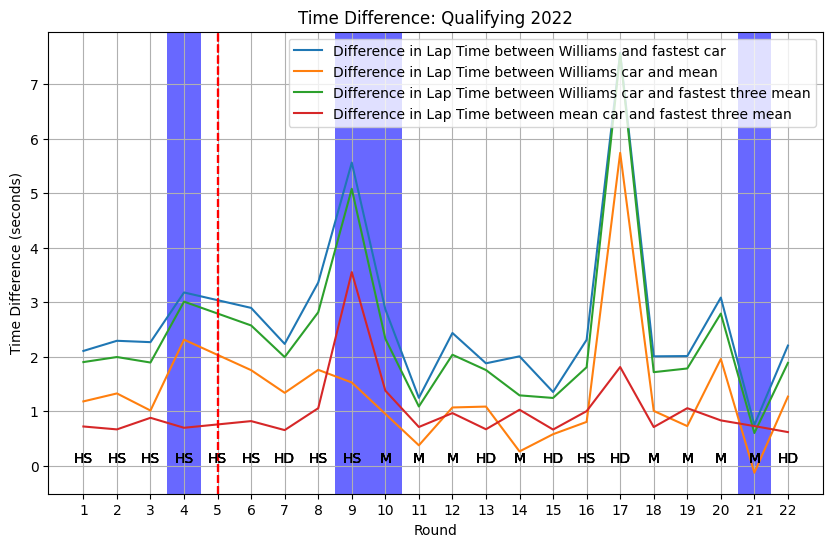

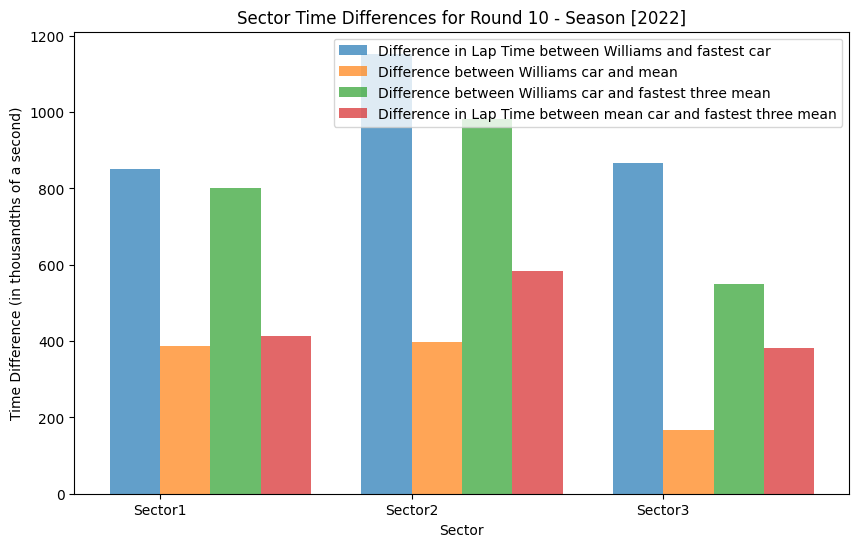

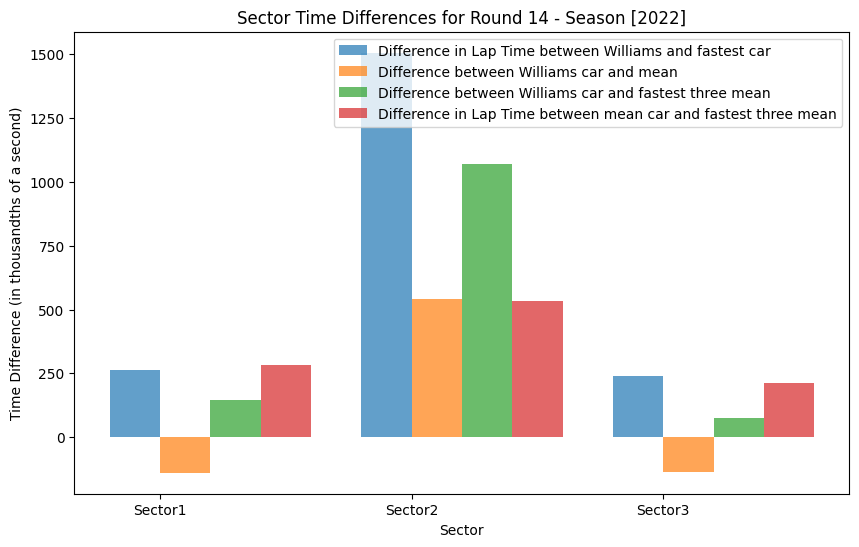

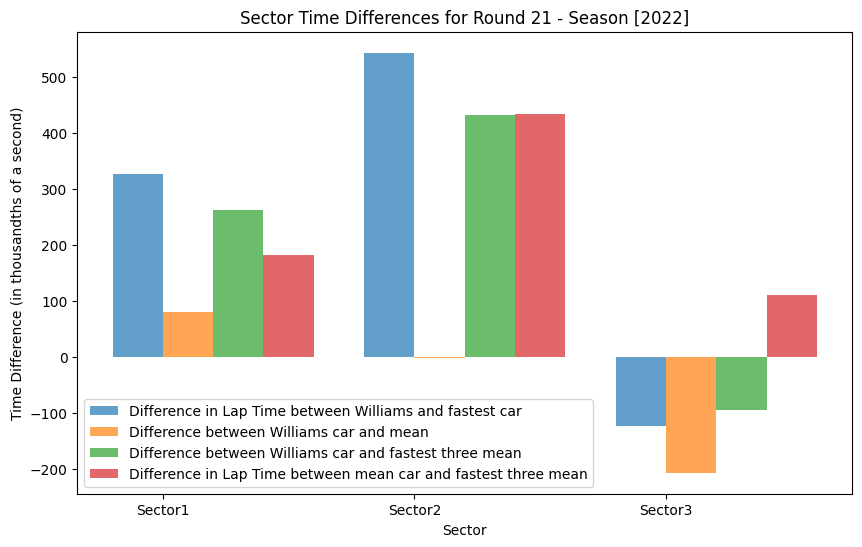

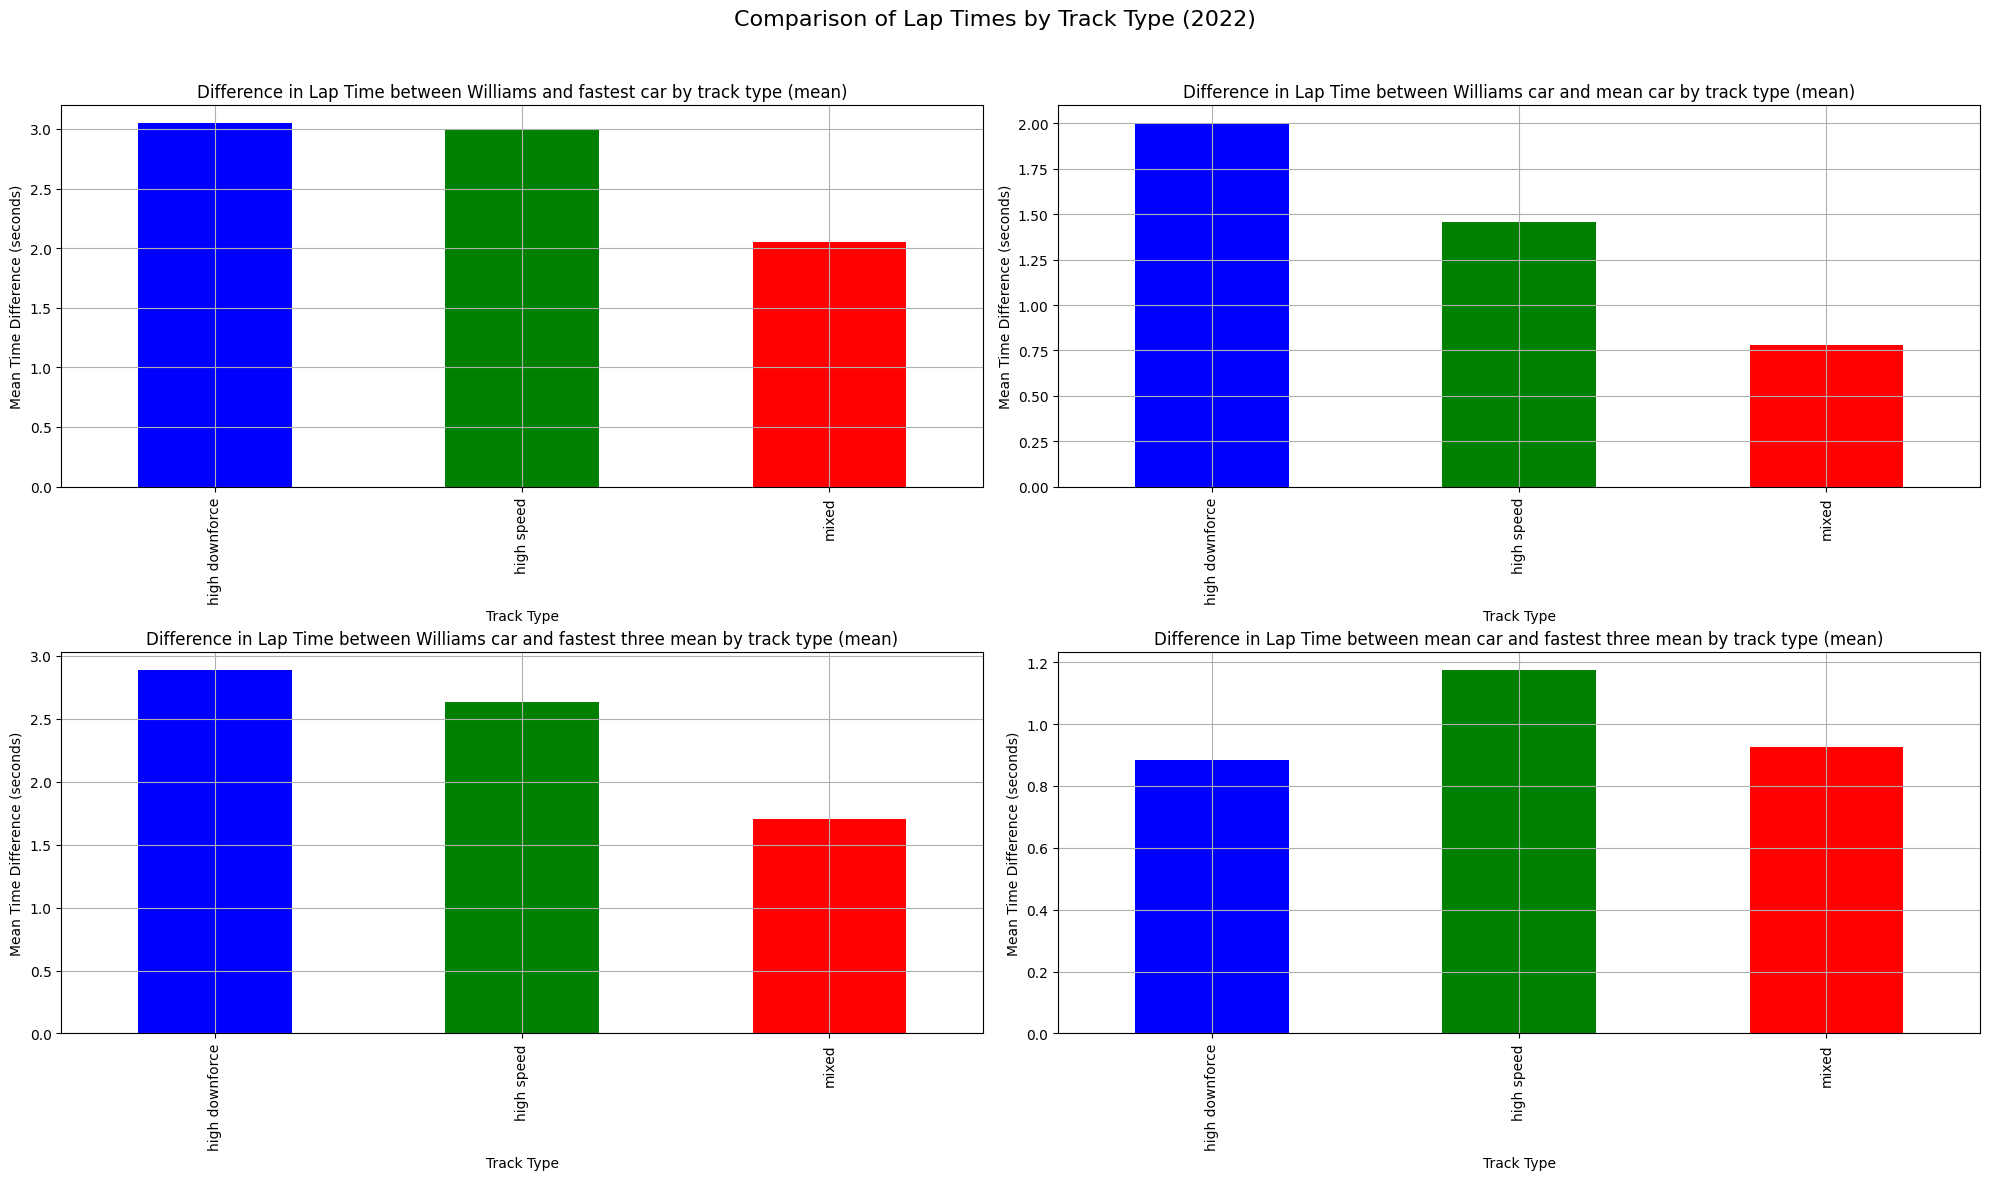

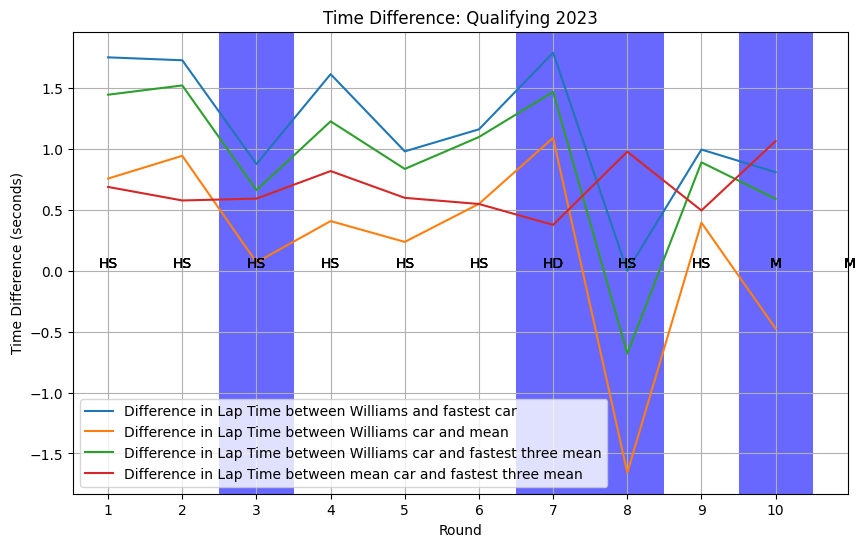

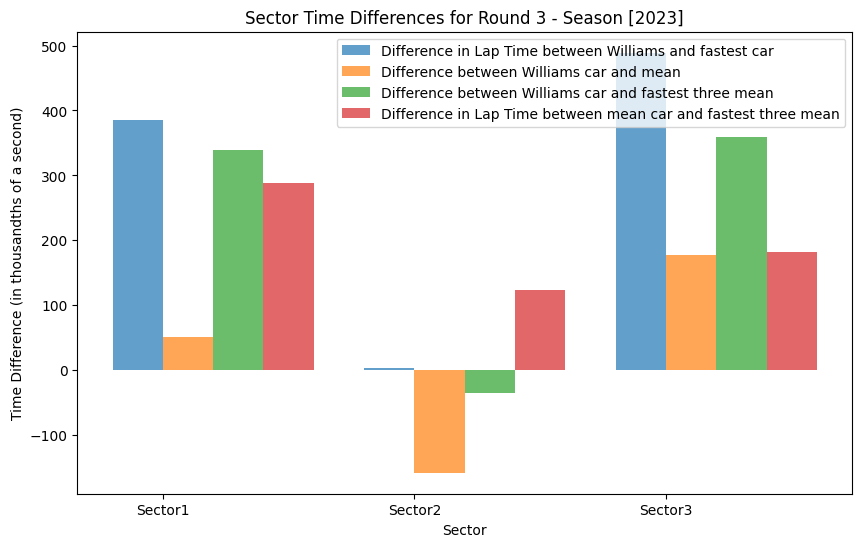

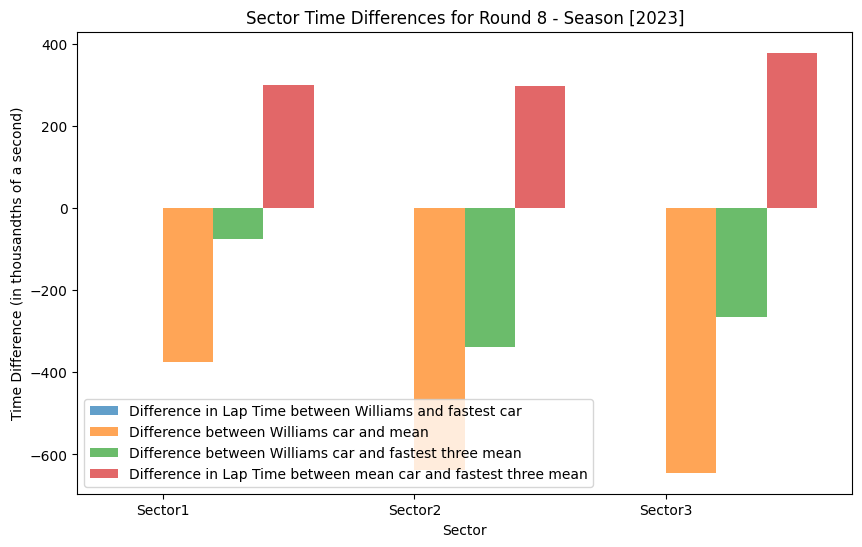

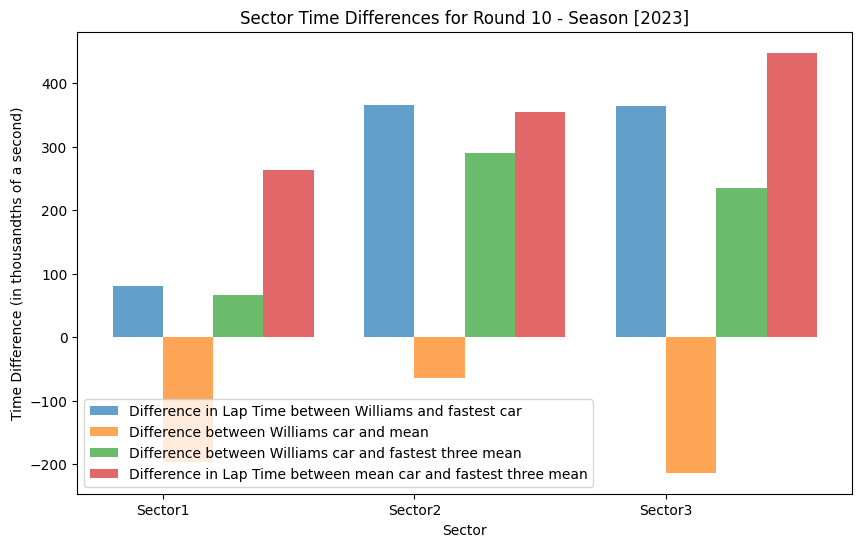

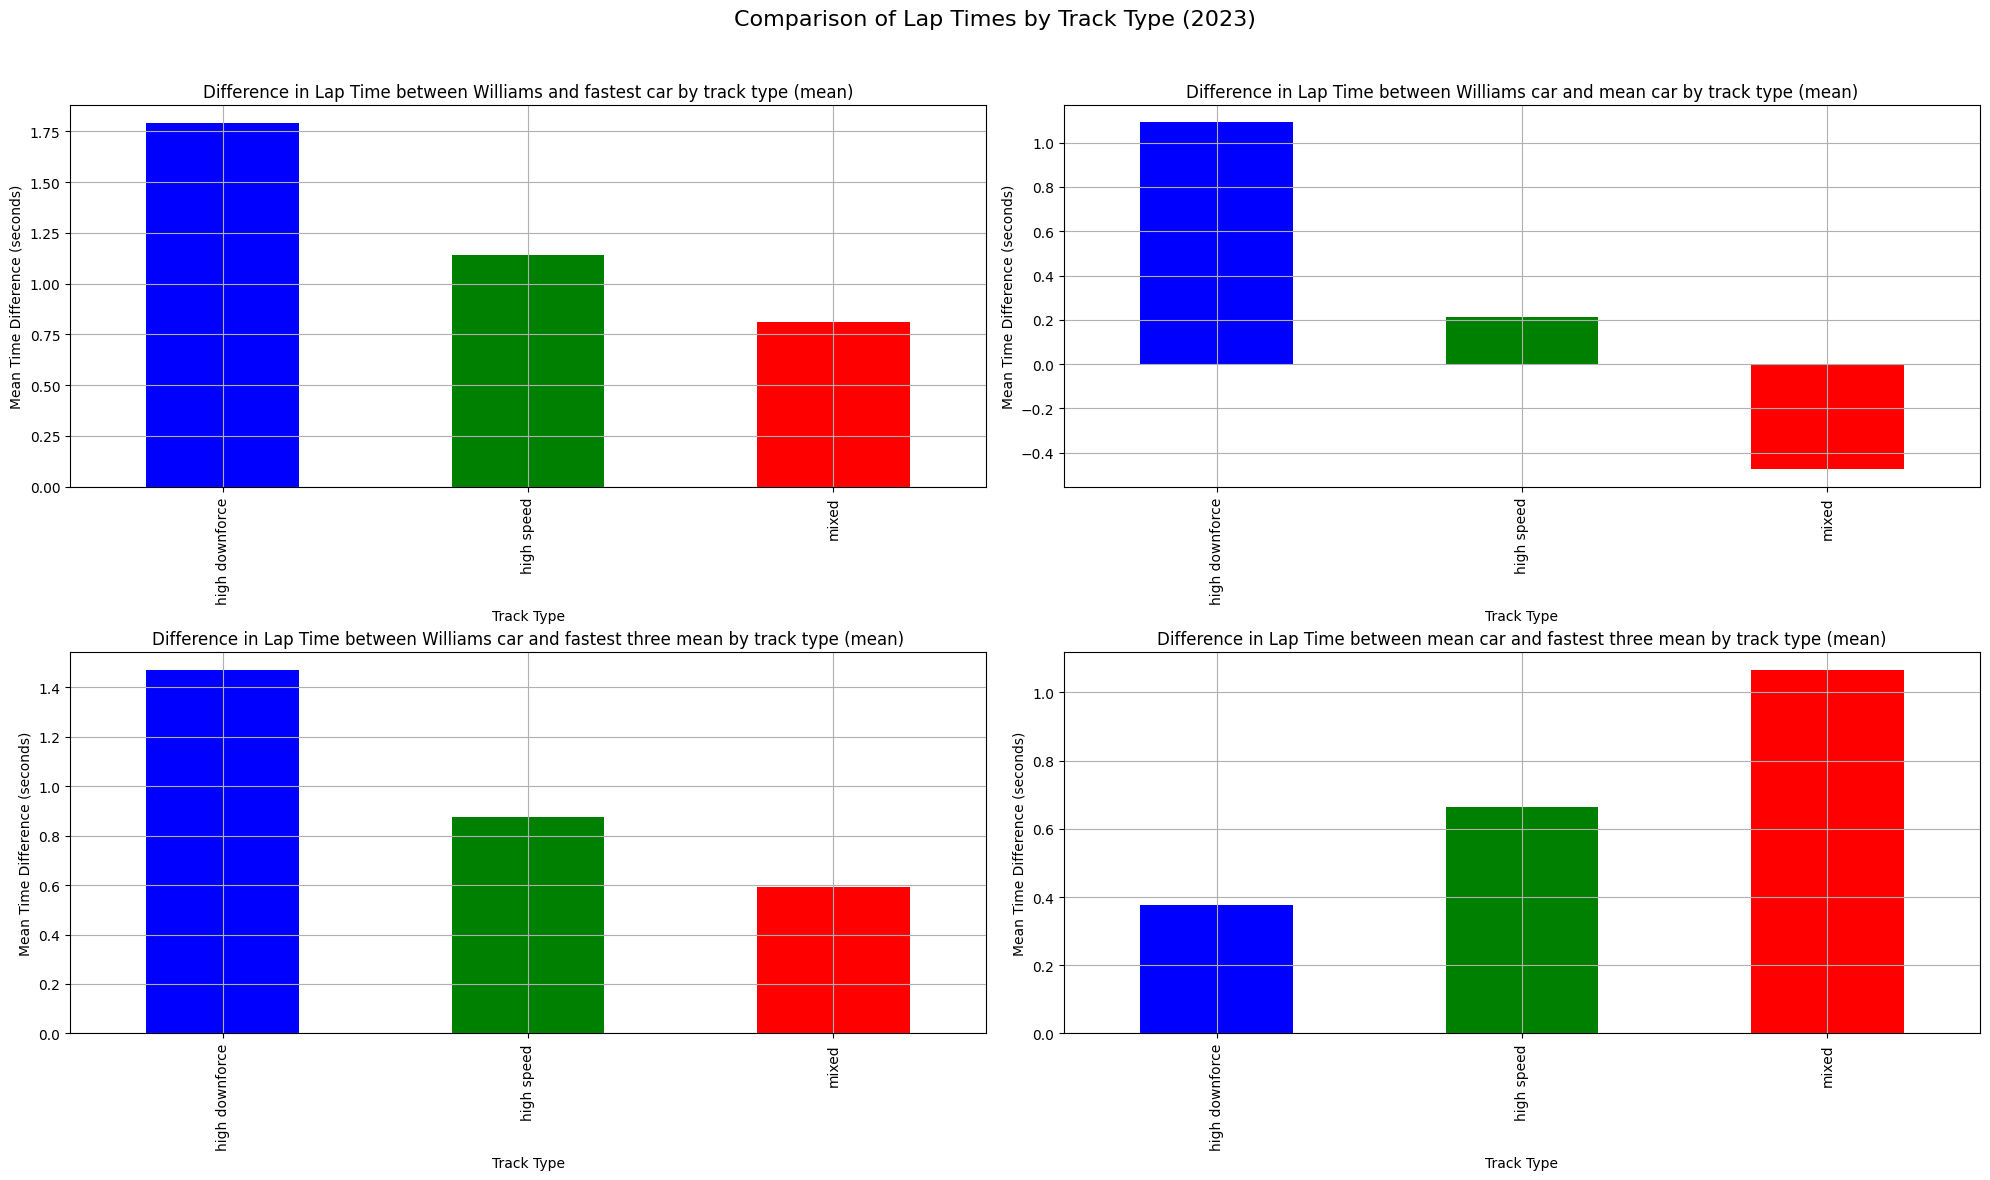

In [18]:
# Qualifying plots 2022 -----------------------------------------------------------------------------------

    
# Plotting time diff
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title('Time Difference: Qualifying 2022')
plot_time_diff(williams_qp_22, fastest_qp_22, weather_data_22, track_data, 22, 22, 'Difference in Lap Time between Williams and fastest car', ax)
plot_time_diff(williams_qp_22, average_qp_22, weather_data_22, track_data, 22, 22, 'Difference in Lap Time between Williams car and mean', ax)
plot_time_diff(williams_qp_22, fastest_three_qp_22, weather_data_22, track_data, 22, 22, 'Difference in Lap Time between Williams car and fastest three mean', ax)
plot_time_diff(average_qp_22, fastest_three_qp_22, weather_data_22, track_data, 22, 22, 'Difference in Lap Time between mean car and fastest three mean', ax)
plt.show()

# Plotting sector time diff
plot_sector_time_differences(
    [williams_qp_22, williams_qp_22, williams_qp_22, average_qp_22],
    [fastest_qp_22, average_qp_22, fastest_three_qp_22, fastest_three_qp_22],
    [10,14,21],
    ['Difference in Lap Time between Williams and fastest car', 'Difference between Williams car and mean', 'Difference between Williams car and fastest three mean', 'Difference in Lap Time between mean car and fastest three mean'],
    [2022]
)

# Plotting time diff type
fig, axs = plt.subplots(2, 2, figsize=(20,12))  # creates a 2x2 grid of Axes objects
fig.suptitle('Comparison of Lap Times by Track Type (2022)', fontsize=16)
# Flattens the 2D array to 1D array for easy indexing
axs = axs.flatten()
plot_time_diff_type(williams_qp_22, fastest_qp_22, weather_data_22, track_data, 22, 22,'Difference in Lap Time between Williams and fastest car by track type (mean)', axs[0])
plot_time_diff_type(williams_qp_22, average_qp_22, weather_data_22, track_data, 22, 22,'Difference in Lap Time between Williams car and mean car by track type (mean)', axs[1])
plot_time_diff_type(williams_qp_22, fastest_three_qp_22, weather_data_22, track_data, 22, 22,'Difference in Lap Time between Williams car and fastest three mean by track type (mean)', axs[2])
plot_time_diff_type(average_qp_22, fastest_three_qp_22, weather_data_22, track_data, 22, 22,'Difference in Lap Time between mean car and fastest three mean by track type (mean)', axs[3])
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


# Qualifying plots 2023 -----------------------------------------------------------------------------------

    
# Plotting time diff
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title('Time Difference: Qualifying 2023')
plot_time_diff(williams_qp_23, fastest_qp_23, weather_data_23, track_data, 23, 10, 'Difference in Lap Time between Williams and fastest car', ax)
plot_time_diff(williams_qp_23, average_qp_23, weather_data_23, track_data, 23, 10, 'Difference in Lap Time between Williams car and mean', ax)
plot_time_diff(williams_qp_23, fastest_three_qp_23, weather_data_23, track_data, 23, 10, 'Difference in Lap Time between Williams car and fastest three mean', ax)
plot_time_diff(average_qp_23, fastest_three_qp_23, weather_data_23, track_data, 23, 10, 'Difference in Lap Time between mean car and fastest three mean', ax)
plt.show()

# Plotting sector time diff
plot_sector_time_differences(
    [williams_qp_23, williams_qp_23, williams_qp_23, average_qp_23],
    [fastest_qp_23, average_qp_23, fastest_three_qp_23, fastest_three_qp_23],
    [3,8,10],
    ['Difference in Lap Time between Williams and fastest car', 'Difference between Williams car and mean', 'Difference between Williams car and fastest three mean', 'Difference in Lap Time between mean car and fastest three mean'],
    [2023]
)

# Plotting time diff type
fig, axs = plt.subplots(2, 2, figsize=(20,12))
fig.suptitle('Comparison of Lap Times by Track Type (2023)', fontsize=16)
axs = axs.flatten()
plot_time_diff_type(williams_qp_23, fastest_qp_23, weather_data_23, track_data, 23, 10,'Difference in Lap Time between Williams and fastest car by track type (mean)', axs[0])
plot_time_diff_type(williams_qp_23, average_qp_23, weather_data_23, track_data, 23, 10,'Difference in Lap Time between Williams car and mean car by track type (mean)', axs[1])
plot_time_diff_type(williams_qp_23, fastest_three_qp_23, weather_data_23, track_data, 23, 10,'Difference in Lap Time between Williams car and fastest three mean by track type (mean)', axs[2])
plot_time_diff_type(average_qp_23, fastest_three_qp_23, weather_data_23, track_data, 23, 10,'Difference in Lap Time between mean car and fastest three mean by track type (mean)', axs[3])
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## Plotting - Displaying Plots (Race)

This script uses the `matplotlib` library to produce a range of plots that visualize race pace data for the Williams racing team for the years 2022 and 2023.

Initially, it generates **Time Difference Plots** for both years. These line plots, created with the `plot_time_diff` function, display the lap time difference between the Williams car and several comparison groups for each round: the fastest car, the average car, and the mean of the fastest three cars. Additionally, the time difference between the average car and the mean of the fastest three cars is also plotted.

Subsequently, the code generates **Sector Time Differences Plots**. These bar plots are created using the `plot_sector_time_differences` function, illustrating the time difference in each sector of the race for specified rounds between the Williams car and the comparison groups.

Finally, **Time Difference by Track Type Plots** are generated. These bar plots, created using the `plot_time_diff_type` function, depict the average time difference by track type for the Williams car and the comparison groups.

This visualization allows comparison of the Williams car's race pace to that of the fastest car, the average car, and the fastest three cars across various track types and sectors. It provides insights into areas where the Williams car might require improvements and where it exhibits good race pace.


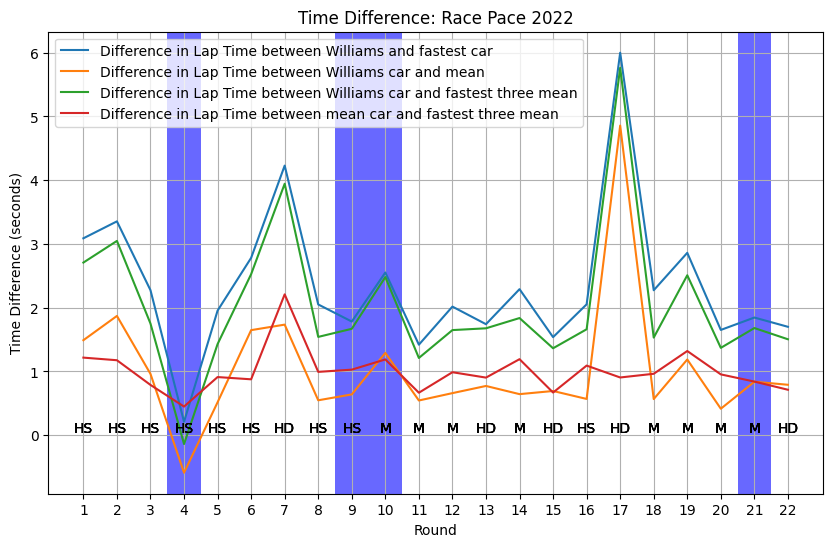

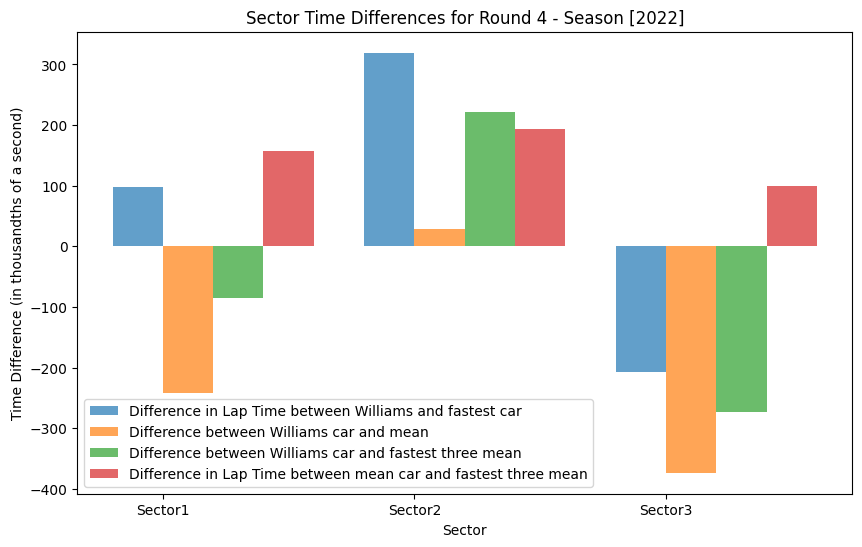

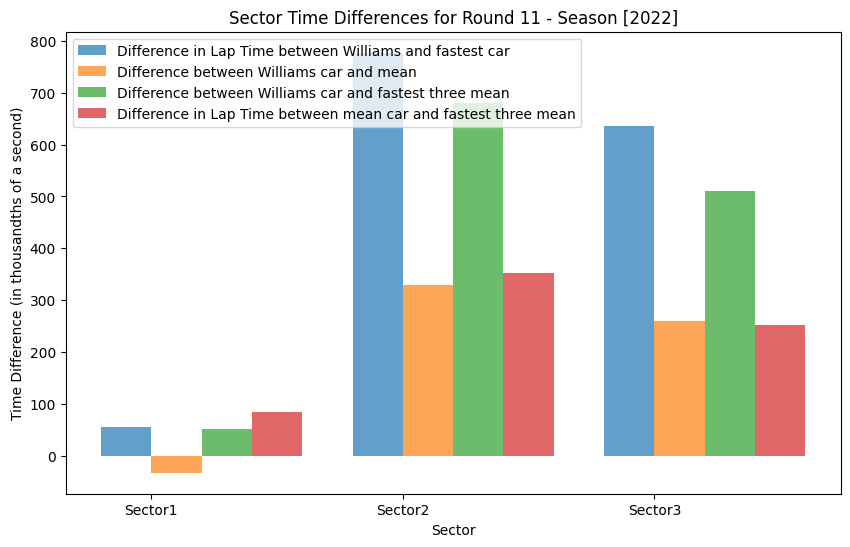

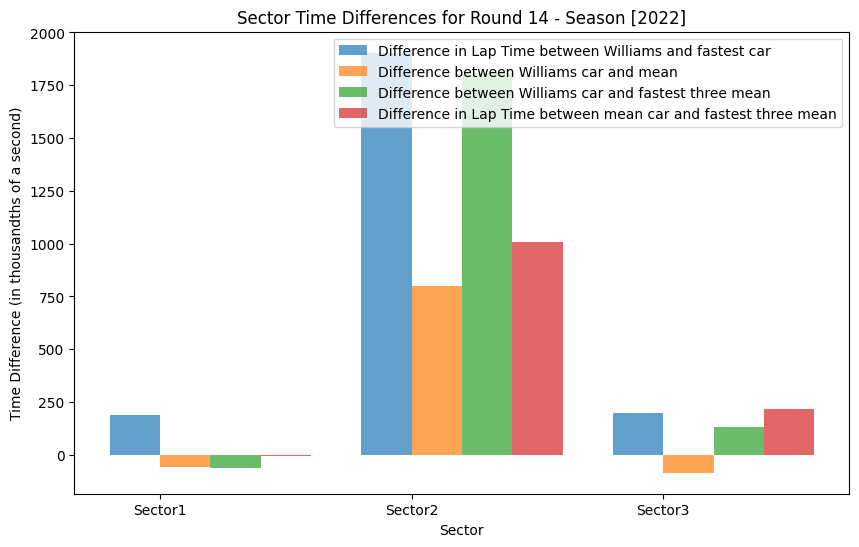

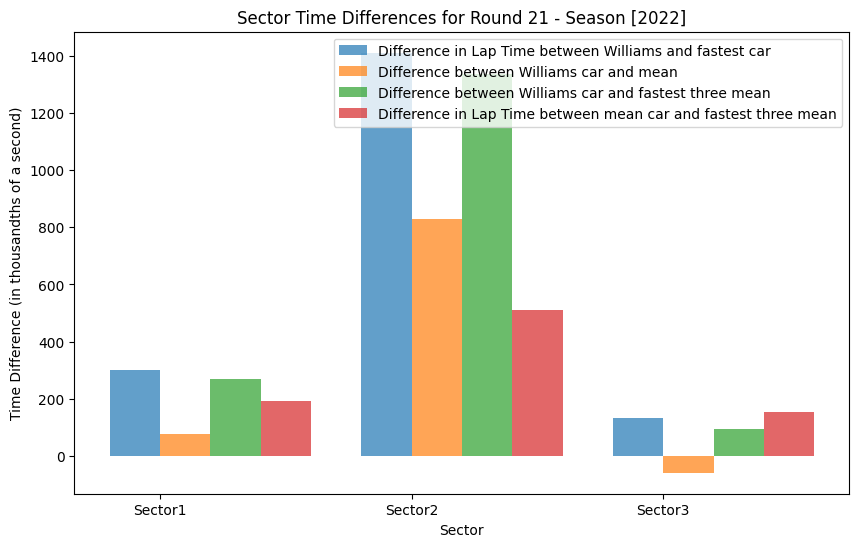

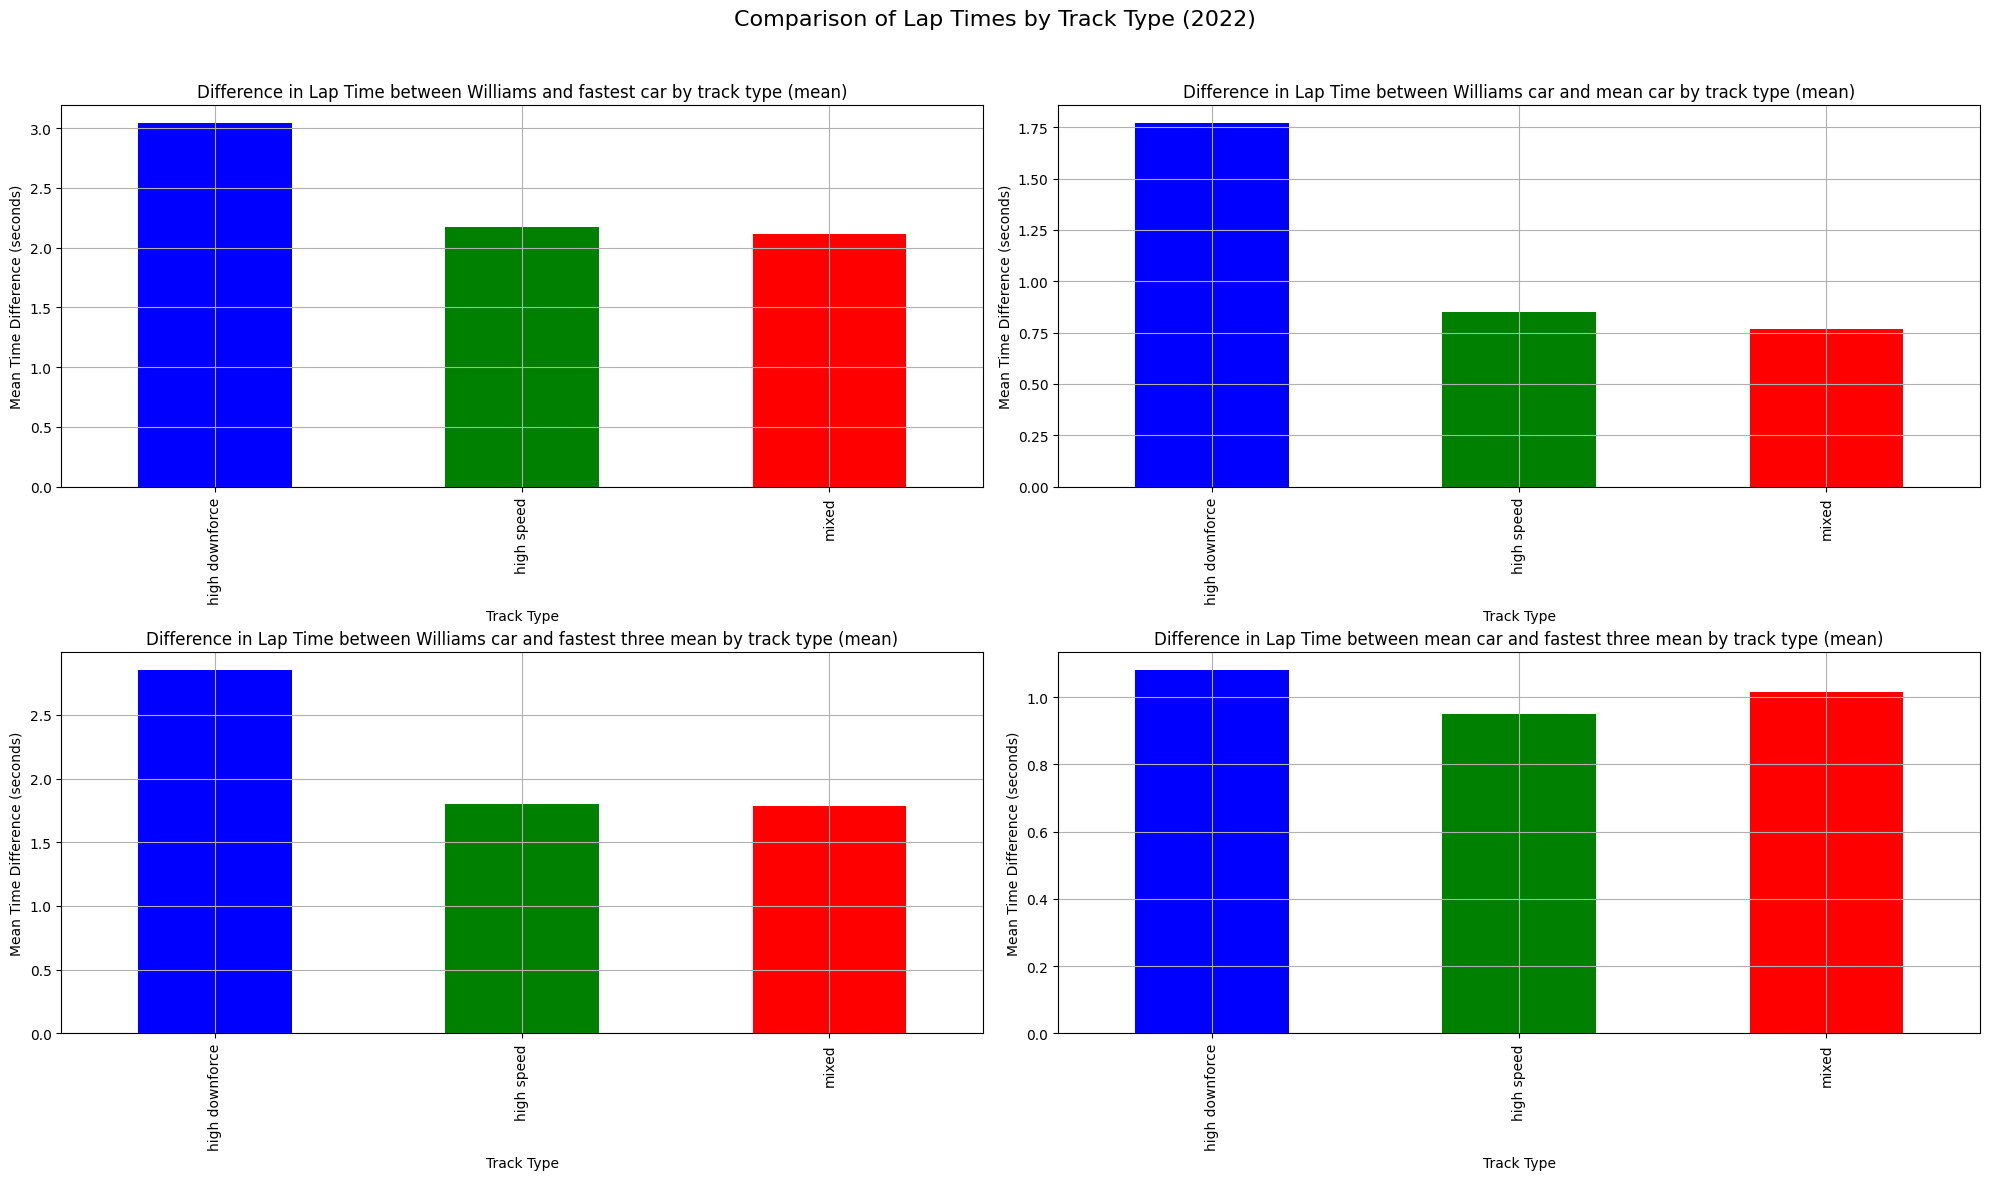

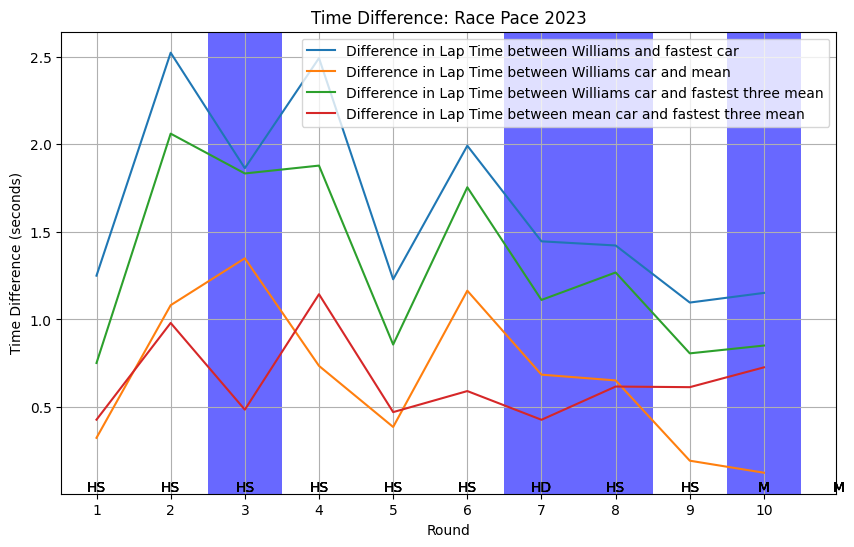

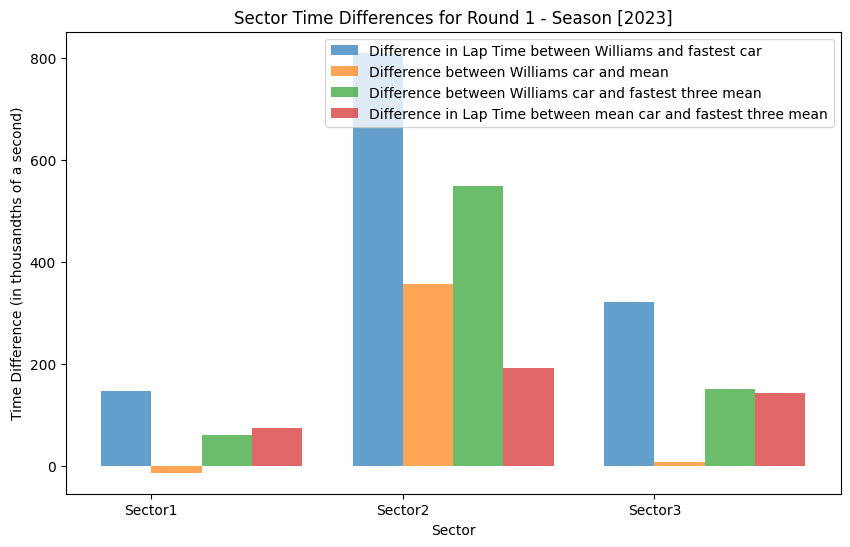

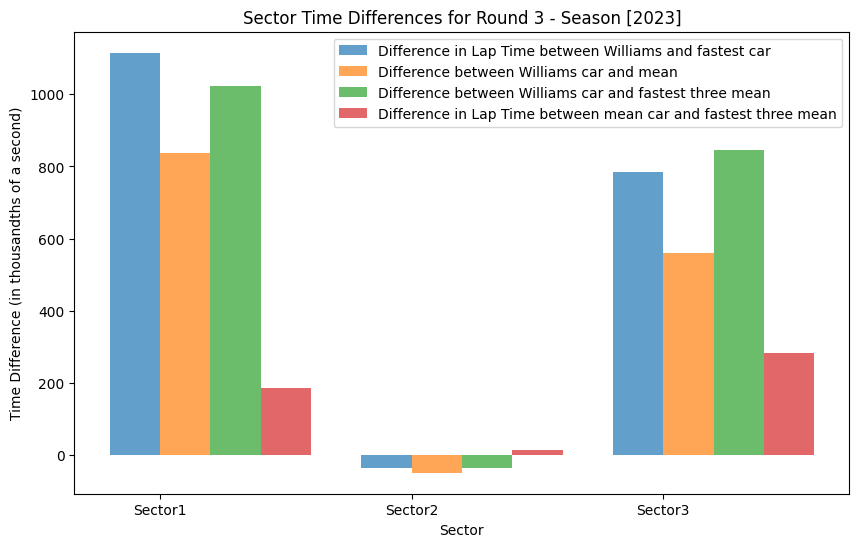

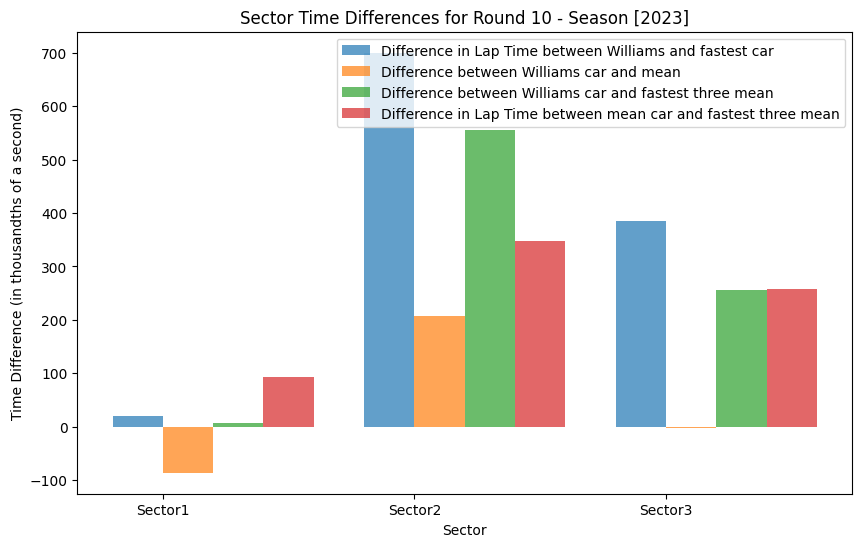

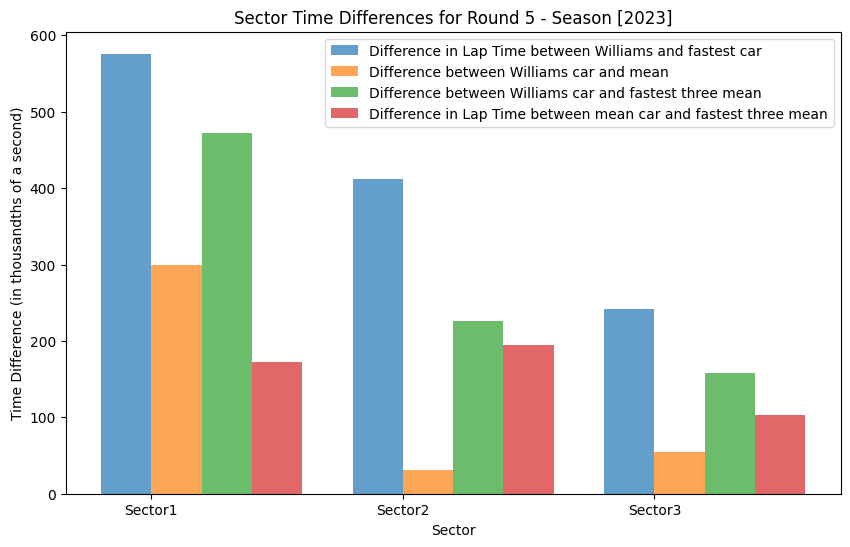

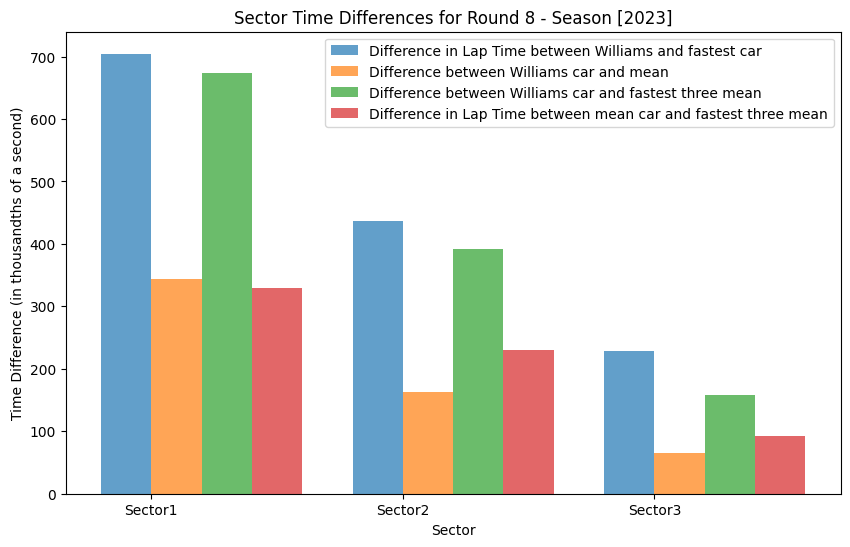

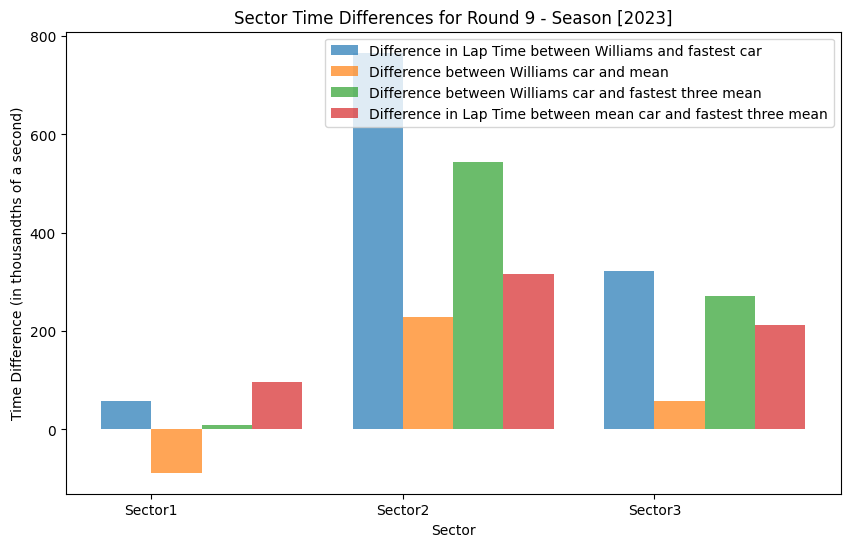

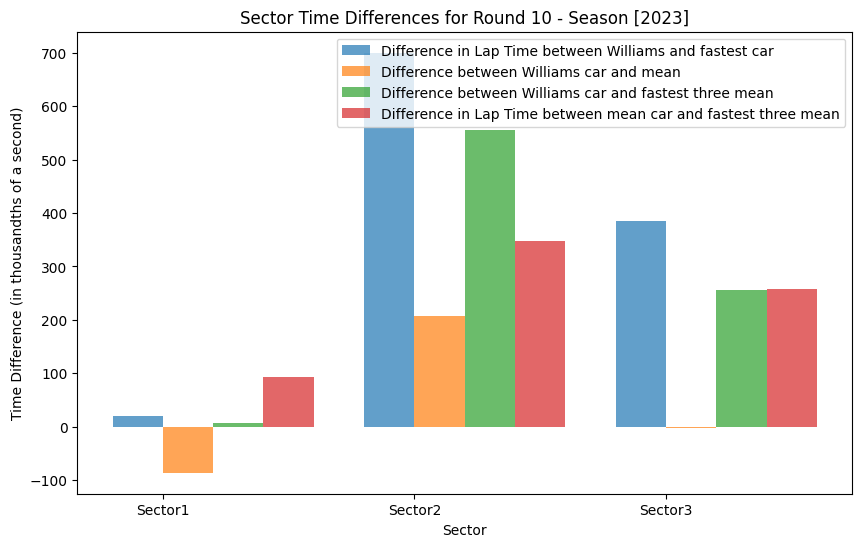

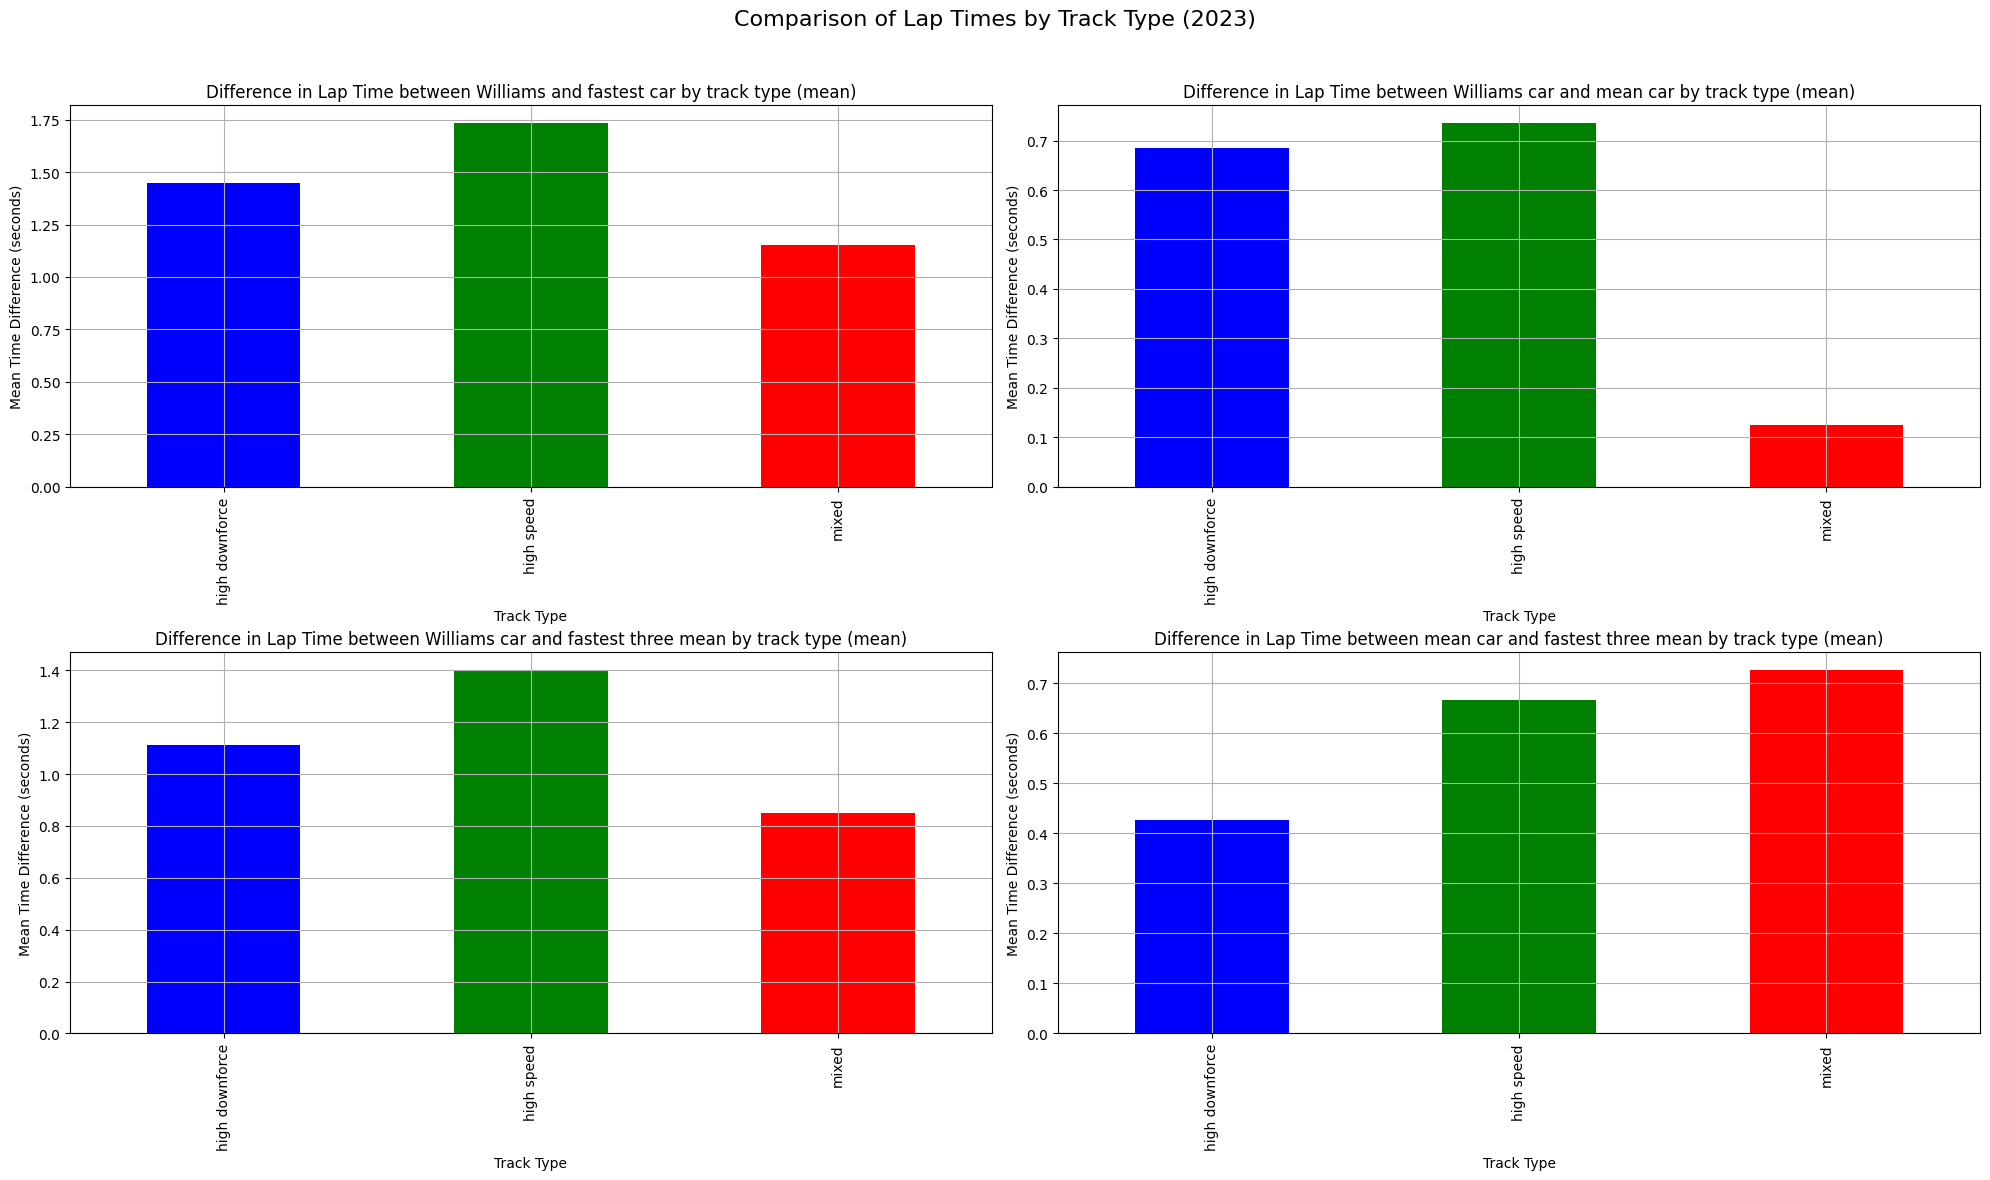

In [19]:
# Race pace plots 2022 -----------------------------------------------------------------------------------

# Plotting time diff
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title('Time Difference: Race Pace 2022')
plot_time_diff(williams_rp_22, fastest_rp_22, weather_data_22, track_data, 22, 22, 'Difference in Lap Time between Williams and fastest car', ax)
plot_time_diff(williams_rp_22, average_rp_22, weather_data_22, track_data, 22, 22, 'Difference in Lap Time between Williams car and mean', ax)
plot_time_diff(williams_rp_22, fastest_three_rp_22, weather_data_22, track_data, 22, 22, 'Difference in Lap Time between Williams car and fastest three mean', ax)
plot_time_diff(average_rp_22,  fastest_three_rp_22, weather_data_22, track_data, 22, 22, 'Difference in Lap Time between mean car and fastest three mean', ax)
plt.show()

# Plotting sector time diff
plot_sector_time_differences(
    [williams_rp_22, williams_rp_22, williams_rp_22, average_rp_22],
    [fastest_rp_22, average_rp_22, fastest_three_rp_22, fastest_three_rp_22],
    [4,11,14,21],
    ['Difference in Lap Time between Williams and fastest car', 'Difference between Williams car and mean', 'Difference between Williams car and fastest three mean', 'Difference in Lap Time between mean car and fastest three mean'],
    [2022]
)

# Plotting time diff type 
fig, axs = plt.subplots(2, 2, figsize=(20,12))  # creates a 2x2 grid of Axes objects
fig.suptitle('Comparison of Lap Times by Track Type (2022)', fontsize=16)
axs = axs.flatten()
plot_time_diff_type(williams_rp_22, fastest_rp_22, weather_data_22, track_data, 22, 22,'Difference in Lap Time between Williams and fastest car by track type (mean)', axs[0])
plot_time_diff_type(williams_rp_22, average_rp_22, weather_data_22, track_data, 22, 22,'Difference in Lap Time between Williams car and mean car by track type (mean)', axs[1])
plot_time_diff_type(williams_rp_22, fastest_three_rp_22, weather_data_22, track_data, 22, 22,'Difference in Lap Time between Williams car and fastest three mean by track type (mean)', axs[2])
plot_time_diff_type(average_rp_22, fastest_three_rp_22, weather_data_22, track_data, 22, 22,'Difference in Lap Time between mean car and fastest three mean by track type (mean)', axs[3])
plt.tight_layout()
plt.subplots_adjust(top=0.9) # Adjust the padding for the title
plt.show()

# Race pace plots 2023 -----------------------------------------------------------------------------------

# Plotting time diff
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title('Time Difference: Race Pace 2023')
plot_time_diff(williams_rp_23, fastest_rp_23, weather_data_23, track_data, 23, 10, 'Difference in Lap Time between Williams and fastest car', ax)
plot_time_diff(williams_rp_23, average_rp_23, weather_data_23, track_data, 23, 10, 'Difference in Lap Time between Williams car and mean', ax)
plot_time_diff(williams_rp_23, fastest_three_rp_23, weather_data_23, track_data, 23, 10, 'Difference in Lap Time between Williams car and fastest three mean', ax)
plot_time_diff(average_rp_23,  fastest_three_rp_23, weather_data_23, track_data, 23, 10, 'Difference in Lap Time between mean car and fastest three mean', ax)
plt.show()

# Plotting sector time diff
plot_sector_time_differences(
    [williams_rp_23, williams_rp_23, williams_rp_23, average_rp_23],
    [fastest_rp_23, average_rp_23, fastest_three_rp_23, fastest_three_rp_23],
    [1,3,10,5,8,9,10],
    ['Difference in Lap Time between Williams and fastest car', 'Difference between Williams car and mean', 'Difference between Williams car and fastest three mean', 'Difference in Lap Time between mean car and fastest three mean'],
    [2023]
)

# Plotting time diff type
fig, axs = plt.subplots(2, 2, figsize=(20,12))
fig.suptitle('Comparison of Lap Times by Track Type (2023)', fontsize=16)
axs = axs.flatten()
plot_time_diff_type(williams_rp_23, fastest_rp_23, weather_data_23, track_data, 23, 10,'Difference in Lap Time between Williams and fastest car by track type (mean)', axs[0])
plot_time_diff_type(williams_rp_23, average_rp_23, weather_data_23, track_data, 23, 10,'Difference in Lap Time between Williams car and mean car by track type (mean)', axs[1])
plot_time_diff_type(williams_rp_23, fastest_three_rp_23, weather_data_23, track_data, 23, 10,'Difference in Lap Time between Williams car and fastest three mean by track type (mean)', axs[2])
plot_time_diff_type(average_rp_23, fastest_three_rp_23, weather_data_23, track_data, 23, 10,'Difference in Lap Time between mean car and fastest three mean by track type (mean)', axs[3])
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


## Exporting - All Data

In [1]:
# save_path = "/Users/alexbuswell/Desktop/Williams/Williams_Test"

# Save Qualifying data
williams_qp_22.to_csv(save_path + "williams_qp_22.csv", index=False)
fastest_qp_22.to_csv(save_path + "fastest_qp_22.csv", index=False)
average_qp_22.to_csv(save_path + "average_qp_22.csv", index=False)
fastest_three_qp_22.to_csv(save_path + "fastest_three_qp_22.csv", index=False)

williams_qp_23.to_csv(save_path + "williams_qp_23.csv", index=False)
fastest_qp_23.to_csv(save_path + "fastest_qp_23.csv", index=False)
average_qp_23.to_csv(save_path + "average_qp_23.csv", index=False)
fastest_three_qp_23.to_csv(save_path + "fastest_three_qp_23.csv", index=False)

# Save Race data
williams_rp_22.to_csv(save_path + "williams_rp_22.csv", index=False)
fastest_rp_22.to_csv(save_path + "fastest_rp_22.csv", index=False)
average_rp_22.to_csv(save_path + "average_rp_22.csv", index=False)
fastest_three_rp_22.to_csv(save_path + "fastest_three_rp_22.csv", index=False)

williams_rp_23.to_csv(save_path + "williams_rp_23.csv", index=False)
fastest_rp_23.to_csv(save_path + "fastest_rp_23.csv", index=False)
average_rp_23.to_csv(save_path + "average_rp_23.csv", index=False)
fastest_three_rp_23.to_csv(save_path + "fastest_three_rp_23.csv", index=False)

# Save Other data
weather_data_22.to_csv(save_path + "weather_data_22.csv", index=False)
weather_data_23.to_csv(save_path + "weather_data_23.csv", index=False)
track_data.to_csv(save_path + "track_data.csv", index=False)


NameError: name 'williams_qp_22' is not defined